02805 Social Graphs and Interactions 

Fall 2020, DTU Compute 

# **CHAOS IN CONGRESS?**

# Imports

## Libraries

In [ ]:
#Import/export
import os
import json 
import urllib.request
import pickle
from google.colab import drive

#Analysis for network
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import random
import collections
from scipy import stats, integrate
import networkx as nx
import nltk
import re
import string
from nltk import word_tokenize
import community # the Python Louvain algorithm
from community import generate_dendrogram, partition_at_level
from  itertools import chain, product
from contextlib import suppress

# Analysis for text (additional packages)
import ast
from sklearn.feature_extraction.text import CountVectorizer
import operator
from collections import Counter
from nltk.tokenize.treebank import TreebankWordDetokenizer

#Plotting
import seaborn as sns
import pprint
import wordcloud
from PIL import Image
from matplotlib import gridspec

#Timing loops
from tqdm import tqdm

#Package update warnings remove
pd.options.mode.chained_assignment = None
np.seterr(divide='ignore', invalid='ignore');

In [ ]:
%matplotlib inline
sns.set_theme(style='darkgrid', palette='Set2')
color = '#124429'
figsize=(16,11)

## Setting up directory

Connecting to the source where our data is placed, and mounting this in google drive for easy access. 

In [ ]:
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/SocialGraphs/project"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/SocialGraphs/project

/content/gdrive/My Drive/SocialGraphs/project


In [ ]:
%ls

 congress_members.csv      edges_rolls_agree_113.p
 df_edge_115.csv           edges_rolls_agree_114.p
 df_partition_110.csv      edges_rolls_agree_115.p
 edges_110.p               edges_rolls_agree_116.p
 edges_111.p               forceatlas2/
 edges_112.p               issue_info.csv
 edges_113.p              'Kopi af edges_rolls_agree_110.p'
 edges_114.p              'Kopi af EXPLAINER NOTEBOOK.ipynb'
 edges_115.p               roll_call_vote.csv
 edges_116.p               roll_info.csv
 edges_rolls_agree_110.p   rolls_agree_110.json
 edges_rolls_agree_111.p   test.jpg
 edges_rolls_agree_112.p


In [ ]:
# Uncomment if running for the first time 
#!pip uninstall fa2
#!git clone -q https://github.com/bhargavchippada/forceatlas2
#!pip install git+https://github.com/bhargavchippada/forceatlas2

In [ ]:
from forceatlas2.fa2 import *

# 1. Motivation


### **Introduction**

With the 2020 United States election being close to finished, we once again find ourselves at the end of a long period of time where US politics has been on everyone's lips. But for us Danes, the US political system can appear somewhat chaotic. While the main topic for the 2020 election was the election of the President of the United States, the purpose of the election was also to count votes for the US Congress. 

The US Congress is a bicameral legislature that creates and votes on laws. The Congress consists of two chambers, the US Senate with 100 senators (voting members) and the US House of Representatives with 435 representatives (voting members). In this project, we will be studying voting data from the House of Representatives, and how the voting behaviors has changed over the past 13 years. More specifically, we will be asking ourselves the question: is there chaos in congress? Are the parties polarized, and has this changed over time? Are there patterns to be found in their voting?


### **Intended goal of the analysis and Motivation**

After the 2020 election, we realized there must be an extrordinaty amount of data behind the US political system. Additionally, we found ourselves confused about the system, and wanted to learn more about the trends within the Congress. 

We will be carrying out this report in a hypothesis driven manner. Thus, the goals of this analysis will be formulated with the three hypotheses stated below.

- Hypothesis 1: It is possible to perform a high-level model of the representatives of the US Congress based on the votes they have casted during roll calls over the years, using advanced network analysis and natural languange processing. 

- Hypothesis 2: There are clear distinctions between the two political parties in terms of what bills they vote *yes* for, and they have become more polarized over the years.

- Hypothesis 3: After finding communities based on bills that representatives vote *yes* for, it will be possible to understand what subjects polarizes the communities by performing text analysis on the summaries of the bills they vote *yes* for. 


Please note we had to make changes to the direction of the study compared to what was presented in the video after having conducted the analysis. 

### **Getting the data - Webscrape**

We found inspiration on Github from Github user lobodemonte to scrape data from [www.congress.gov](www.congress.gov) about all congress members and used it to scrape house representatives for the 110th to 116th congress [1].
This was done using the python library called *beautifulsoup4* as it provides easy access to the HTML tags used on the websites of interest. Furthermore, with regex it is easy to identify relevant paragraphs and iterate over them.
Most of the information was provided in a tabular format, which further eases the scrape.

The notebook [Scraping_Congress.ipynb](https://nbviewer.jupyter.org/github/benedictehejgaard/chaos-in-congress/blob/gh-pages/Scraping_Congress.ipynb) gives a thorough explanation of the webscrape we performed with all code, outputs, and intermediate steps. 

### **Description and explanation of the data**


**Terminology and Background**

The members of the House of Representatives are re-elected every two years, and each two-year period is called a *term* in this report. Currently sitting is the 116th House of Representatives, which covers the period from 2019-2021 (Jan. 3rd to Jan. 3rd). We will be examining terms 110-116, which covers the period from January 3rd 2007 to January 3rd 2021 (notice data was pulled on 15-11-2020, hence the 116th term has not come to an end yet. 

Each representative (voting member of the House of Representatives) has a unique member ID consisting of the first letter in their last name and 6 digits (e.g. A000024). A new ID is created for each member; thus they are not reused when a member leaves the house and stay unique for any member of congress.

The laws that the representatives vote for are called *Bills* (often refered to as *Issue*). Each bill has a unique ID, a description, a number of tags (presented later), and a summary. The summary is a piece of text that outlines the law. The method used to vote for a bill is called a *Roll Call*, where each member has the opportunity to cast their vote (not everyone votes). A bill will typically be going through mutiple rounds of voting before a final vote to pass/not pass the bill is cast. Hence, there can be multiple rolls for each bill, representing the next legislative step or amendments to the current bill. Each roll has a *Roll Call Number* which is unique for that year, and a unique Roll Call ID which consists of the year + Roll Call ID. This ID is unique across all terms.

Below, you will find a simple overview of the above described terminology: 

| Terminology    | Description                                                    |
|----------------|----------------------------------------------------------------|
| Representative | A voting member of the House of Representatives                |
| Term           | The two year period that the representatives are elected for   |
| Bill/Issue     | The law proposal/amendment that the house votes for            |
| Bill_ID        | Unique ID for each Bill/Issue                                  |
| Roll Call      | A round of voting for a bill. There can be multiple per bill.  |
| Roll_Call_ID   | Unique ID for a roll call.                                     |


Additionally, the terms *issue* and *bill* will be used interchangeably, and the term *Congress* will only represent the House of Representatives in this report. 

**Explanation of the Datasets**

The result of our webscape has created four .csv files containing different information about the congress. Please see the notebook [Scraping_Congress.ipynb](https://nbviewer.jupyter.org/github/benedictehejgaard/chaos-in-congress/blob/gh-pages/Scraping_Congress.ipynb) for information and code on the webscraping.

The four datasets contain the following:
* roll_call_vote: Containing votes by each representative for all rolls they have participated in
* congress_110_116: Information regarding the representatives in the 110th through the 116th House of Representatives.
* roll_info: Information about the rolls during the 110th through the 116th House of Representatives
* issue_info: Holds summaries and lists of committees per roll

We load these in, along with some basic manipulations:

In [ ]:
# Roll call vote
roll_call_vote = pd.read_csv('roll_call_vote.csv') 
roll_call_vote.rename(columns={'Unnamed: 0':'member_ID'}, inplace=True) # cleaning column names
roll_call_vote = roll_call_vote.set_index('member_ID') # correct index

# congress 110 116
congress_110_116 = pd.read_csv('congress_members.csv')
congress_110_116 = congress_110_116.rename(columns={'rep_id':'member_ID'}, inplace=False) # cleaning column names
congress_110_116 = congress_110_116.set_index('member_ID') # correct index

# roll info
roll_info = pd.read_csv('roll_info.csv')
roll_info.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace = True) # Remove remaining index columns  
roll_info = roll_info.rename(columns={'Issue': 'Date', 'Date': 'Issue'}) # cleaning column names

# issue info
issue_info = pd.read_csv('issue_info.csv')

Further data cleaning and pre-processing can be found in section 2 under *Data Cleaning and Preprocessing*, where the final shape of the dataset also will be presented. 


**Congress_110_116: Congress Member Data**

To have an overview of all members of congress in all terms, we have the *Congress_110_116* dataset. With the unique member_ID as a key, it contains information over the members of the congress since 2007, their political party, state, a URL to their website, and much more. 

Each house of representatives consists of 435 members, however members do not necessarily sit for the full period, and we have a total of 969 members in the dataset – 500 republicans, 468 democrats, and one independent, with 10 attributes before the initial datacleaning. This low number is explained by the fact that most representatives sit for longer than a single term, as they are reelected.
This dataset is 156 kB. 

In [ ]:
print('An example of five entries in the Congress_110_116 dataset:')
congress_110_116.head()

An example of five entries in the Congress_110_116 dataset:


name  ...                                   congress_numbers
member_ID                      ...                                                   
A000014     Abercrombie, Neil  ...  ['102', '103', '104', '105', '106', '107', '10...
A000374    Abraham, Ralph Lee  ...                              ['114', '115', '116']
A000022     Ackerman, Gary L.  ...  ['103', '104', '105', '106', '107', '108', '10...
A000370        Adams, Alma S.  ...                       ['113', '114', '115', '116']
A000366          Adams, Sandy  ...                                            ['112']

[5 rows x 9 columns]

**roll_info: Roll Call Data**

To have an overview of each Roll Call, we have the *Roll_Call* dataset. With the Roll-id as unique key, it contains information on each roll call in terms of the bill that was voted for, the date, the question that was asked, and the result of the voting round. Since each bill has multiple roll calls, the same bill can be present multiple times. 

The dataset also contains the variable *Issue_link* which is a unique https link to the website of the bill voted for. This will be an important variable later, as it ties this dataset to the *Issue_Info* dataset presented below, which contains the summaries of each bill. 

There are 9800 unique roll calls in total. The dataset is 3 MB. 

In [ ]:
print('An example of five entries in the roll_info dataset:')
roll_info.head()

An example of five entries in the roll_info dataset:


Year  Roll  ...    Roll-id                           Vote_link_new
0  2007  1186  ...  2007-1186  https://clerk.house.gov/Votes/20071186
1  2007  1185  ...  2007-1185  https://clerk.house.gov/Votes/20071185
2  2007  1184  ...  2007-1184  https://clerk.house.gov/Votes/20071184
3  2007  1183  ...  2007-1183  https://clerk.house.gov/Votes/20071183
4  2007  1182  ...  2007-1182  https://clerk.house.gov/Votes/20071182

[5 rows x 11 columns]

**issue_info: The summary for each bill/issue**

With *issue_link* as the unique key, the dataset contains a link for each Bill, along with the full summary for each bill. This summary will be used for the later text analysis. The dataset contains 4267 bills, and is 31 MB.

In [ ]:
print('An example of five entries in the issue_info dataset:')
issue_info.head()

An example of five entries in the issue_info dataset:


committees  ...                                            summary
0  ['Senate Appropriations', 'House Appropriations']  ...  Consolidated Appropriations Act, 2008 - Divisi...
1  ['House Energy and Commerce', 'Senate Appropri...  ...  (This measure has not been amended since the C...
2                                                 []  ...  (This measure has not been amended since it wa...
3                           ['House Ways and Means']  ...  (This measure has not been amended since it wa...
4  ['Committee on House Administration', 'House T...  ...  (This measure has not been amended since it wa...

[5 rows x 3 columns]

**roll_call_vote: The result of each Roll Call voting round**

With member_ID as a unique key and Roll_Call_ID as columns, this dataset contains the vote casted at each roll call by each representative. Notice, NaN is present if the member has not voted in that roll call. The dataset is 21 MB. 

In [ ]:
print('An example of five entries in the roll_call_vote dataset:')
roll_call_vote.head()

An example of five entries in the roll_call_vote dataset:


2007-999 2007-998 2007-997  ... 2020-100 2020-10   2020-1
member_ID                             ...                          
A000014        Nay      Aye      Yea  ...      NaN     NaN      NaN
A000374        NaN      NaN      NaN  ...      Aye     Aye  Present
A000022        Nay      Aye      Yea  ...      NaN     NaN      NaN
A000370        NaN      NaN      NaN  ...       No      No  Present
A000366        NaN      NaN      NaN  ...      NaN     NaN      NaN

[5 rows x 9800 columns]

# 2. Basic stats

### **Data Cleaning and Preprocessing**

Before any further data cleaning and preprocessing will be done, the Independent party will be removed in the data set congress_110_116 and roll_call_vote. This independent member is in fact *Bernie Sanders*, who later ran for president for the Democratic Party.

In [ ]:
member_independent = congress_110_116[congress_110_116.party == 'Independent'].index.to_list()
print('Independent party member: ')
congress_110_116.loc[member_independent]

Independent party member: 


name  ...                                   congress_numbers
member_ID                    ...                                                   
S000033    Sanders, Bernard  ...  ['102', '103', '104', '105', '106', '107', '10...

[1 rows x 9 columns]

In [ ]:
roll_call_vote = roll_call_vote[~roll_call_vote.index.isin(member_independent)] # Removing from dataset

In [ ]:
congress_110_116 = congress_110_116[~congress_110_116.index.isin(member_independent)] # Removing from dataset

Since we are working with four different datasets, we will be going through data cleaning and processing for each dataset separately, before any merges are done. This way we can keep a nice overview of the process. 

**Issue Info**

Before we start doing any cleaning, we have to gain an overview of what to clean. The text analysis will be made on the roll call summaries, which are contained in this dataframe. Thus this column need to have value. We check if this is true:

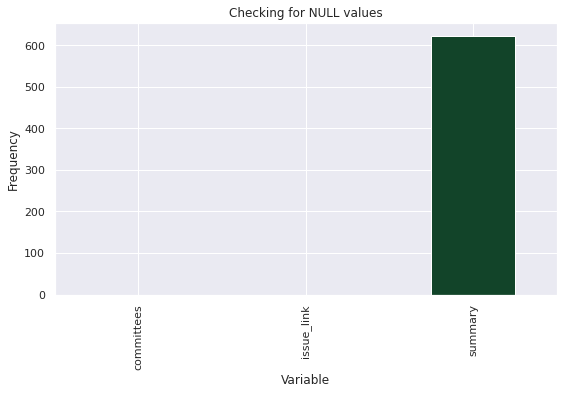

In [ ]:
issue_info.isnull().sum().plot(kind ='bar', color=color, figsize=[9,5]);
plt.title('Checking for NULL values')
plt.ylabel('Frequency')
plt.xlabel('Variable')
plt.show()

Figure 1: Frequency of NULL values for different variables in issue_info.

As the figure illustrates there are over 600 issues that do not have a summary. Hence, we need to remove these. 

In [ ]:
issue_info= issue_info.dropna(subset= ['summary']).reset_index(drop=True) # dropping NaN summaries

There are also summaries that only contain blank space, hence these will also be removed. 

In [ ]:
issue_info_space = issue_info.summary.str.split().str.len()
issue_info = issue_info[issue_info_space != 0].reset_index(drop=True)

print(f"Final shape of dataframe containing summary for rolls are: \nRolls(rows) = {issue_info.shape[0]}")

Final shape of dataframe containing summary for rolls are: 
Rolls(rows) = 3639


**Roll Info**

The roll_info should only contain rolls which have a summary:

In [ ]:
# Keeping rows which issue_link is in issue_info
roll_info = roll_info[roll_info['Issue_link'].isin(issue_info['issue_link'].tolist())]

We will now investigate if there are any required columns with NaN-values, which we should should not have. 

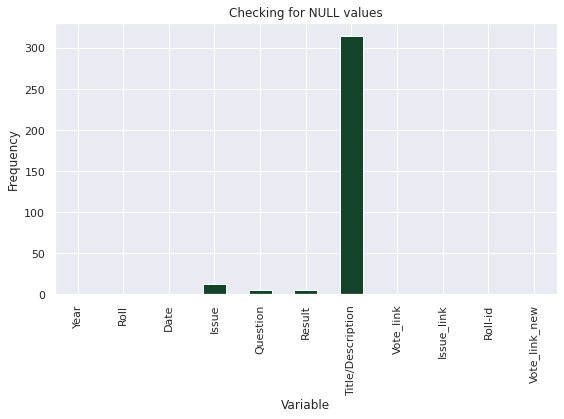

In [ ]:
roll_info.isnull().sum().plot(kind = 'bar', color=color, figsize=[9,5]);
plt.title('Checking for NULL values')
plt.ylabel('Frequency')
plt.xlabel('Variable')
plt.show()

Figure 2: Frequency of NULL values for different variables in roll_info.

The only columns that should not have NaN-values are issue and results, since we are not using the Title/Descriptions of the rolls

In [ ]:
# removing nan in results
roll_info.dropna(subset=['Result'], inplace=True)
roll_info.dropna(subset=['Issue'], inplace=True)

Most bills that are presented in congress will have several votes, and only the latest vote is included in the analysis, such that each bill is represented by a single vote.

Each vote may constitute the next legislative step, or an amendment to the current bill proposal.

Furthermore, if these were not removed, identical summaries may appear in the text analysis which would skew the results. By only focusing on the last vote, we are sure to focus only on the longest and most accurate summary of each bill. 

In [ ]:
# sort the values after date so we only keep the latest rolls and summaries
roll_info = roll_info.sort_values('Date').drop_duplicates('Issue',keep='last')

# Define a list of roll call IDs that we keep.
# Will be used to filter/merge other tables for the desired rolls. 
keep_rolls = roll_info['Roll-id']

print(f"Amount of roll call IDs to keep:", len(keep_rolls))

print(f"\nFinal shape of dataframe containing roll call information is: \nRolls and Bills (rows) = {roll_info.shape[0]}")

Amount of roll call IDs to keep: 3082

Final shape of dataframe containing roll call information is: 
Rolls and Bills (rows) = 3082


The initial roll count was 9800, which is now reduced to 3082 - This will in turn reduce the edge weights in the graph. 

**Roll Call Vote**

First, we remove all the roll calls discussed above.

In [ ]:
#Indexing votes using roll-ids
roll_call_vote = roll_call_vote[keep_rolls]

Furthermore, we notice there are multiple methods of answering; *yes*, *yea*, *no*, *nay*, thus the roll call votes are changed to binary:
* 1 for 'Yes', 'Yea', and 'Aye'
* 0 for 'No', and 'Nay'

Notice that 'Not voting' is purposely left out of this particular study, despite the potential explanatory power that may reside in these votes.

In [ ]:
# Creating dict that will give 1 if a member votes "yes", and 0 if they vote "no"
answer_dict = {
    "Yes" : 1,
    "No"  : 0,
    "Aye" : 1,
    "Nay" : 0,
    "Yea" : 1,
    "Not Voting": np.nan
}

roll_call_vote = roll_call_vote.apply(lambda x: x.map(answer_dict), axis=1)

We will be removing all members who have not voted for anything. This may occur if members have only sat in congress for a short period of time or their votes have been filtered out by the previous steps. This would happen automatically when constructing the graph, as these members would not have any edges.

In [ ]:
roll_call_vote = roll_call_vote[roll_call_vote.sum(axis = 1) !=0]
print('Example of voting pattern for two members:')
roll_call_vote.head(2)

Example of voting pattern for two members:


2008-151  2019-138  2008-150  ...  2009-691  2008-575  2019-515
member_ID                                ...                              
A000014         1.0       NaN       1.0  ...       1.0       1.0       NaN
A000374         NaN       NaN       NaN  ...       NaN       NaN       NaN

[2 rows x 3082 columns]

In [ ]:
print(f"Final shape of dataframe containing overview of what each member has voted: \nMembers(rows), Roll_Calls(cols) = {roll_call_vote.shape}")

Final shape of dataframe containing overview of what each member has voted: 
Members(rows), Roll_Calls(cols) = (916, 3082)


**Congress 110 116**

This dataset contains information for all terms, which we wish to extract on individual congresses.

To ease the future filtering, each congress number is added as a binary variable to indicate which periods a member has served in.

In [ ]:
terms = ['110', '111', '112', '113', '114', '115', '116']

for term in terms:
  congress_110_116[term] = [1 if term in row else 0 for row in congress_110_116['congress_numbers']]

print(f"Final shape of dataframe containing Congress member information is: \nMembers (rows) = {congress_110_116.shape[0]}\n")

print('Example of information for two members:')
congress_110_116.head(2)

Final shape of dataframe containing Congress member information is: 
Members (rows) = 968

Example of information for two members:


name  ... 116
member_ID                      ...    
A000014     Abercrombie, Neil  ...   0
A000374    Abraham, Ralph Lee  ...   1

[2 rows x 16 columns]

**Merging Datasets for Network Analysis**

The data used to build the network is made by merging the dataset *congress_110_116* and *roll_call_vote* on member_id. 

By using inner-join, we ensure that no members are included that have not voted, for the same reasons as stated above.

In [ ]:
congress_roll =  congress_110_116.merge(roll_call_vote, how='inner', left_index = True, right_index = True)

This gives the following dataset for further analysis:

In [ ]:
print(f'The final shape of dataframe for Network Analysis: \nrows, cols = {congress_roll.shape}\n')
print('Example of information for two members:')
congress_roll.head(2)

The final shape of dataframe for Network Analysis: 
rows, cols = (916, 3098)

Example of information for two members:


name  ... 2019-515
member_ID                      ...         
A000014     Abercrombie, Neil  ...      NaN
A000374    Abraham, Ralph Lee  ...      NaN

[2 rows x 3098 columns]

**Text Analysis data:** 

In order to create a final dataset that contains the full information about each bill and their summary, we merge issue_info and roll_info on 'issue_link' which is the unique identifier for rolls and their summaries. 

In [ ]:
roll_summary =  issue_info.merge(roll_info, how='inner', 
                                 left_on = 'issue_link', right_on='Issue_link')

Which gives us one large dataset for further analysis:

In [ ]:
print(f'The final shape of dataframe for Text Analysis: \nrows, cols = {roll_summary.shape}')
roll_summary.head(2)

The final shape of dataframe for Text Analysis: 
rows, cols = (3082, 14)


committees  ...                          Vote_link_new
0  ['Senate Appropriations', 'House Appropriations']  ...  https://clerk.house.gov/Votes/2007538
1  ['House Energy and Commerce', 'Senate Appropri...  ...  https://clerk.house.gov/Votes/2008543

[2 rows x 14 columns]

### **Basic Exploratory Statistics**

Now that our data is cleaned and ready for analysis, we can perform some basic statistics to get and idea of the data that we are working with.

Initially, we display basic statistics on the voting pattern for each term and for each roll call.

In [ ]:
print('Statistics on the number of terms and the voting pattern for all terms')
congress_roll.describe()

Statistics on the number of terms and the voting pattern for all terms


110         111         112  ...    2009-691    2008-575    2019-515
count  916.000000  916.000000  916.000000  ...  416.000000  409.000000  405.000000
mean     0.451965    0.442140    0.434498  ...    0.997596    0.955990    0.945679
std      0.497959    0.496912    0.495962  ...    0.049029    0.205368    0.226930
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000  ...    1.000000    1.000000    1.000000
50%      0.000000    0.000000    0.000000  ...    1.000000    1.000000    1.000000
75%      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000

[8 rows x 3089 columns]

Overall, we notice some insights that explain the behavior of the members. We notice on bill `2008-151` everyone has voted for the bill (minimum value and avg. value is 1). We also notice that not everyone votes for every bill. For instance, bills number `2013-435` and `2013-436` are both in year 2013 and right after one another, but 7 members did not vote for the second bill. Furthermore, for the majority of the votes it is evident that the representatives either completely disagree (avg. vote around 0.5) or completely agree (avg. vote around 0.9-1.0). 

Further insights could be derived but would not be directly relevant for testing the hypotheses. 

We now dive into the two political parties, Democrats and Republican. We wish to examine the distribution between the parties throughout the terms. 

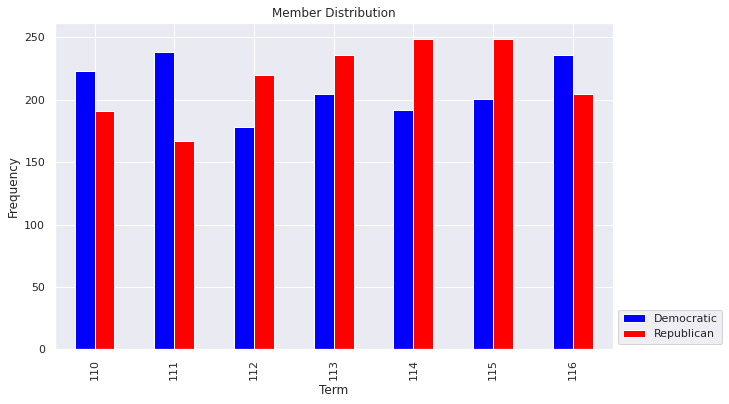


 Member distribution over the terms:


110  111  112  113  114  115  116
Democratic  223  238  178  205  192  201  236
Republican  191  167  220  236  249  249  205
TOTAL       414  405  398  441  441  450  441

In [ ]:
congress_roll.groupby(['party'])[terms].sum().T.plot(kind ='bar', 
                                                     color={"Democratic": "blue", 
                                                            "Republican": "red"}, 
                                                     figsize=[10,6], 
                                                     title = 'Member Distribution', 
                                                     xlabel = 'Term', 
                                                     ylabel = 'Frequency').legend(loc='lower left',
                                                                                  bbox_to_anchor=(1.0, 0))
plt.show()

print('\n Member distribution over the terms:')
congress_count = congress_roll.groupby(['party'])[terms].sum()
congress_count.append(congress_count.sum(numeric_only=True), 
                      ignore_index=True).rename(index={0: 'Democratic', 
                                                       1: 'Republican', 
                                                       2: 'TOTAL'})

Figure 3: Frequency of members in the House of Representatives over the different terms. The table shows the distribution count, along with the total number of members in each term.

We know that for the congress, which party is in the lead is a major factor in getting bills passed/not passed through. Hence, it is highly relevant to take this distribution of the members of the House of Representatives into consideration when examining the voting patterns over time. In figure 3, we see that from terms 110-111 (2007-2010) and again in term 116 (2019-2020) there was an overweight of democrats in the House of Representatives, whereas from terms 112-115 (2011-2018) there was an overweight of Republicans. Interestingly enough, the majority party in the house is almost disproportional with the party of the sitting United States President. 

Furthermore, in the distribution table, we notice a varying total voter count. The House always has 435 members, however, representatives can end their service earlier for a number of reasons. If we look at the congress with the most total members (115th) we see 450. This was investigated by looking at the terms of service on [www.history.house.gov](www.history.house.gov) for the 115th congress, showing many members leaving this particular congress [2]. This will not impact the analysis, as these members inevitably will have fewer votes, and thus be less significant in terms of edge-weights for the network as a whole.

To further examine whether the party distribution has an influence in the overall voting pattern in the House of Representives, we plot the frequency of voting responses over the years. 

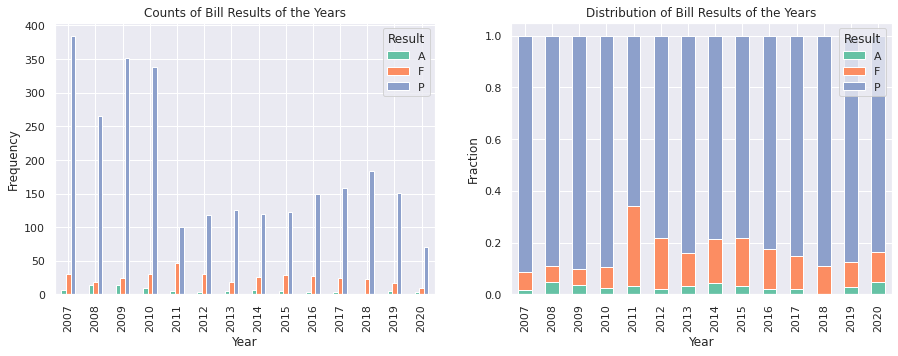

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

roll_summary.groupby(['Year','Result'])['Result'].count().unstack().plot(kind ='bar', 
                                                                         ylabel='Frequency', 
                                                                         title = 'Counts of Bill Results of the Years',
                                                                         figsize=[15,5], ax=axes[0])

roll_frac = roll_summary.groupby(['Year','Result'])['Result'].count()
roll_frac.groupby(level=0).apply(lambda x:  x / float(x.sum())).unstack().plot(kind ='bar', 
                                                                               ylabel='Fraction', 
                                                                               title = 'Distribution of Bill Results of the Years',
                                                                               figsize=[15,5], ax=axes[1], 
                                                                               stacked=True)


plt.show()

Figure 4: (a) Counts of voting results over the years, (b) distribution of voting results over the years. A = amended, F = Failed, P = Passed.

During 2007-2010 there was a significantly higher amount of bills being passed than in the following years. This could be tied to the distribution of the parties in those years. However, it is relevant to consider historic event as well, since these years fall during and after the financial crisis. We notice a drastic fall in number of bills proposed from 2010 to 2011, which is also the years that the house went from having a democratic majority to a republican majority, all under a democratic President.

The distribution of bills as well as their responses should be taken into consideration in the further analysis. E.g. for term 112 we could have much less bills to base the analysis on than e.g. for term 111. 

Each bill comes with a summary, but it can be non-trivial how long these summaries are. This perspective will be relevant in our later text analysis, thus we will generate some basic insights on the text that we gain from the summaries of the bills (which will be used for text analysis later).

Initially, we examine the average number of characters in the summaries (notice no text cleaning for stopwords etc. has been done).

In [ ]:
roll_summary_count = roll_summary.summary.str.len() # Count words in summary
roll_summary_count_mean = roll_summary_count.mean() # Avg. of count
roll_summary_len = roll_summary['summary'].str.split().str.len() # Count characters in summary
roll_summary_len_mean = roll_summary_len.mean() # Avg. of count

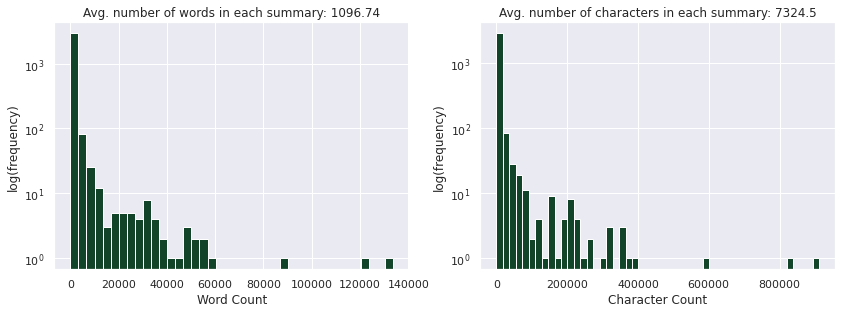

In [ ]:
fig = plt.figure()

plt.subplot(2, 2, 1)
roll_summary_len.hist(bins =40, log=True , figsize=[14,10], color=color)
plt.title(f"Avg. number of words in each summary: {np.round(roll_summary_len_mean,2)}") 
plt.xlabel('Word Count')
plt.ylabel("log(frequency)")

plt.subplot(2, 2, 2)
roll_summary_count.hist(bins =50, log=True, color=color)
plt.title(f"Avg. number of characters in each summary: {np.round(roll_summary_count_mean,2)}") 
plt.xlabel('Character Count')
plt.ylabel("log(frequency)")

plt.show()

Figure 5: Average number of words in each summary, as well as average number of characters in each summary. The y-axis has been log-transformed to account for the exponential difference in counts. Each entry is a summary.

We see that most bills fall to the shorter end of the scale (notice the log-scale). A few summaries are of longer character. This will be taken into consideration in the later text analysis, as we wish to not assign more frequency to a certain words solemnly based on the fact that the summaries it is mentioned in, are longer than average. 

Lastly, we examine the seniority of the members of the House of Representatives, in which we examine how many terms they have served. While this will not have a direct impact on our analysis, we find it a general prejudice that there is much seniority in the house, thus it will be interesting to derive. 


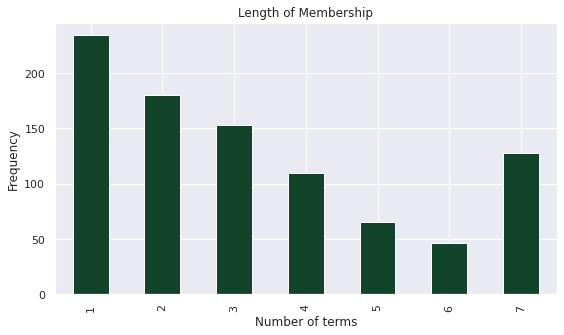

In [ ]:
fig = plt.figure()
congress_roll[terms].sum(axis=1).value_counts().sort_index().plot(kind = 'bar',  
                                                                  figsize = [9,5], 
                                                                  color=color)
plt.title( 'Length of Membership') 
plt.xlabel('Number of terms')
plt.ylabel('Frequency')
plt.show()

Figure 6: The seniority in the House of Representatives. X-axis displays how many terms a representative has served, and the y-axis displays the frequency of representatives in each bin.

We notice it appears that most members only sit for 1-3 terms. However, we must remember that although not present in this dataset, most members could be sitting in the house both before 110. Since we see a steady decline in the seniority, it could indicate that these are members that have sat for many previous terms before 110. The spike at 7/7 terms emphasize this. 

Now that we have a general understanding of the data we are working with, we can proceed with the analyses that will test our hypotheses. 

# 3. Tools, theory and analysis

**Overall Idea**

In the following, we will be going through three steps in order to test our hypotheses. Initially, we will be generating the network based on different theories for density reduction and edge weights. Next, we will be performing community detection in this network, in order to investigate potential polarizations. Lastly, we will be performing text analysis based on the summaries of each bill, and compare the most frequent words across the communities found in the previous analysis. 

## **Analysis 1: Building the network**

Before we are able to test our hypotheses, we have to build a network. As previously mentioned, we wish to create a network of representatives, connected by the roll calls they have voted for. We have tested several heuristics to achieve this goal, however first the data was manipulated to a desirable format to construct the edges. Namely, we are interested in constructing node-pairs and counting how often they agree/disagree on bills in the following ways:
* Agree yes: Both voting yes
* Agree no: Both voting no
* Agree: Total agree yes and agree no
* Disagree: One yes, one no

Finally, we wish to differentiate between the congresses by constructing a single graph per congress, such that we are able to compare the results at a later stage. Therefore, the first step is to define functions to build the necessary datastructures per congress. 

In [ ]:
def congress_number_data(congress_number):
  '''Function to extract data from the main dataframe concerning a single congress

  Returns
    Dataframe with congress members as rows, attributes and their votes for each roll call as columns
  '''
  # Extracting relevant congress members
  congress_year = congress_110_116[congress_110_116[congress_number] == 1]

  # Extracting relevant roll call vote columns
  year0 = congress_year_dict[congress_number][0]
  year1 = congress_year_dict[congress_number][1]
  roll_call_vote_year = congress_roll.filter(regex=f"{year0}|{year1}")
  
  #Combining in new dataframe
  final_temp =  congress_year.merge(roll_call_vote_year, how='left', 
                                    left_index = True, right_index = True)
  
  return final_temp

congress_year_dict = {
    "110" : ["2007", "2008"],
    "111"  : ["2009", "2010"],
    "112" : ["2011", "2012"],
    "113" : ["2013", "2014"],
    "114" : ["2015", "2016"],
    "115": ["2017", "2018"],
    "116": ["2019", "2020"]
}

### Functions for generating edges

In the following, two functions are defined to help generate edges.

* **Term_edges**: Function to calculate agreement between representatives on all rolls in a given congress.
* **Term_edge_creage**: Constructs dictionaries containing all edges and their attributes - In this case the count of roll calls members agree/disagree on.

Note that the second function merely generates files to ease the future computation of both graphs and text analysis.

In [ ]:
def term_edges(congress_number):
  '''Compute agreement on all rolls for each pair of representatives for the congress in question

  Returns
    Node-pairs constituting an edges with a column per roll and an associated number:
    0 for agree no
    1 for disagree
    2 for agree yes
  '''
  # Defining the term table
  term_table = congress_number_data(congress_number)
  
  # New column identical to member_ID
  term_table['member_ID_edge'] = term_table.index

  # Cross-multiply the two columns such that all rows are combined with eachother (including itself)
  prod = product(term_table.index.unique(), term_table['member_ID_edge'].unique()) 

  # Turn into dataframe where we for each member ID int he first column have 
  # the other member IDs int he second column
  df_prod = pd.DataFrame([list(p) for p in prod]).rename(columns={0: "node1", 1: "node2"}) 
  
  # Remove self-loops
  df_edge = df_prod[df_prod['node1'] != df_prod['node2']]

  # Ensure each pair is only present once by removing 'reversed' duplicates
  df_edge = df_edge[df_edge[['node1', 'node2']].apply(frozenset, axis=1).duplicated()].reset_index(drop=True) 

  return df_edge

In [ ]:
def term_edge_create(congress_number):
  '''Construct and save edge files

  Saves two files:
    - Dict of edges paired with count of agree, agree yes, agree no, disagree and 
    the share of each out of the total rolls two members have both voted on.
    - Dict of edges paired with a list of roll-ids of all agree yes rolls between two members 
  '''
  # Load data
  df_edge = term_edges(congress_number)
  df_members = congress_number_data(congress_number)

  # Filter votes
  year0 = congress_year_dict[congress_number][0] # first term year
  year1 = congress_year_dict[congress_number][1] # second term year
  df_year = df_members.filter(regex=f"{year0}|{year1}")

  # Prepare dicts
  edge_dict = {}
  rolls_dict_yes = {} #holds roll-ids that each edge-pair agrees on

  # Looping through member pairs to count votes in agreement
  for members in df_edge.itertuples(index=False):
    temp = df_year.loc[[members[0], members[1]]].sum()

    #If sum is 0 or 2, members agree either 'no' or 'yes', thus we extract the roll-id
    temp_no = temp[temp.isin([0])].index.to_list()
    temp_yes = temp[temp.isin([2])].index.to_list()
    temp_disagree = temp[temp.isin([1])].index.to_list()
    temp_dict = {
        'agree_yes': len(temp_yes), 
        'agree_no': len(temp_no),
        'agree': len(temp_no) + len(temp_yes), 
        'disagree': len(temp_disagree)
        }

    edge_dict[tuple(members)] = temp_dict
    rolls_dict_yes[tuple(members)] = temp_yes
  
  with open(f'edges_{congress_number}.p', 'wb') as fp:
    pickle.dump(edge_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
  with open(f'edges_rolls_agree_{congress_number}.p', 'wb') as fp:
    pickle.dump(rolls_dict_yes, fp, protocol=pickle.HIGHEST_PROTOCOL)

We now create all the dictionaries of edges and save them as a .p file. Below, we then load in these files for further analysis. Please note this step is necessary as an average computer most likely will run out of RAM space if file is simply loaded "locally" in the notebook.

In [ ]:
%%time
term_edge_create("110")
term_edge_create("111")
term_edge_create("112")
term_edge_create("113")
term_edge_create("114")
term_edge_create("115")
term_edge_create("116")

CPU times: user 26min 40s, sys: 2.23 s, total: 26min 42s
Wall time: 26min 45s


We now load in the .p edge files created above, and the graphs can now be constructed from the files. The following three functions are used for this purpose.

In [ ]:
def term_edge_load(congress_number):
  '''Loads edge dictionary

  Returns
    Edge dictionary. 
    Keys are edge tuples of representatives. 
    Values are attributes, consisting of agreement counts
  '''
  with open(f'edges_{congress_number}.p', 'rb') as fp:
    edge_dict = pickle.load(fp)
  return edge_dict

In [ ]:
def congress_dict(congress_number):
  '''Create dictionary containing node attributes for each representative

  Returns
    Dictionary of representatives and their corresponding attributes; name, party and state
  '''
  # Create dict where keys are member ID and values are info for creating nodes
  congress_df = congress_number_data(congress_number)
  congress_dict = congress_df[['name','party','state' ]].to_dict('index')
  return congress_dict

In [ ]:
def create_graph(congress_number):
  '''Constructs NetworkX graph from edges and nodes defined from 
  repsectivly term_edge_load and congress_dict.

  Returns
    Graph object with the relevant node and edge attributes.
  '''
  # Loading data and graph
  edges = term_edge_load(congress_number)
  G = nx.Graph()

  #Creating edges
  G.add_edges_from(edges.keys())
  nx.set_edge_attributes(G, edges)
  
  
  #Adding node attributes
  node_attrs = congress_dict(congress_number)
  nx.set_node_attributes(G, node_attrs)
  
  return G

The 110th congress will be used as an example

In [ ]:
%%time
G_110 = create_graph('110')
print(f'Number of nodes: {len(G_110)}')
print(f'Number of edges: {len(G_110.edges())}')

Number of nodes: 415
Number of edges: 85905
CPU times: user 317 ms, sys: 5.84 ms, total: 323 ms
Wall time: 664 ms


We are now able to efficiently generate graphs with the desired edge attributes to be used as weights in the analysis.

Now, we will prepare functions for plotting the graphs in a meaningful way using ForceAtlas2

Note that we are using an adapted version of the ForceAtlas2 algorithm that includes edge weights. This was found on GitHub, and used since the edge weights are important in this particular network, as displayed in the first two graph plots below. Code was provided by GitHub user 'bhargavchippada'[3].

In [ ]:
def color_nodes(G):
  '''Function to determine node colors depending on parties

  Returns
    Red if republican
    Blue if democrat
  '''
  color_nodes = ["Red" if nx.get_node_attributes(G,'party')[node] == 'Republican' 
                 else "Blue" for node in list(G.nodes()) ]
  return color_nodes


def color_edges(G):
  '''Function to determine edge color depending on party of start and end node

  Returns
    Blue if democrat - democrat
    Red if republican - republican
    Purple if inter-party edge
  '''
  dd_color = "#ADD8E6"
  rr_color = "#FA8072"
  dr_color = "#EE82EE"

  color_edges = [dr_color if nx.get_node_attributes(G, 'party')[edge[0]] != nx.get_node_attributes(G, 'party')[edge[1]] 
                else rr_color if nx.get_node_attributes(G, 'party')[edge[0]] == 'Republican' 
                else dd_color
                for edge in list(G.edges())]

  return color_edges

def size_nodes(G):
  '''Function to determine size of nodes depending on degree

  Returns
    List of degrees per node
  '''
  node_size = [d for n, d in G.degree()] # The size of each node will equal their degree
  return node_size

In [ ]:
def fa2_pos(G, iter, edge_weight="agree", edge_weight_influence=1):
  '''Configuring the ForceAtlas2 object to provide positions for plotting the graphs

  Returns
    Positions of nodes and edges to be drawn using NetworkX

  '''
  fa2_obj = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=edge_weight_influence,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)
  
  positions = fa2_obj.forceatlas2_networkx_layout(G, pos=None, iterations=iter, 
                                                  weight_attr=edge_weight)
  return positions

In [ ]:
def print_fa2(G, iter, edge_weight='agree', edge_weight_influence=1):
  '''Plotting the graph using positions provided by ForceAtlas2

  Returns
    Nothing
  '''
  col_nodes = color_nodes(G)
  col_edges = color_edges(G)
  nod_size = size_nodes(G)
  positions = fa2_pos(G, iter, edge_weight, edge_weight_influence)

  nx.draw_networkx_nodes(G, positions, node_size=nod_size, node_color=col_nodes, alpha=0.6)
  nx.draw_networkx_edges(G, positions, edge_color=col_edges, alpha=0.9)
  plt.rcParams["figure.figsize"] = [10,10]
  plt.axis('off')
  plt.ion()
  plt.show()

### Graph construction and analysis
In the following, we will be using the graph representing the 110th congress to test our hypotheses before extrapolating to the remaining congresses.

First of all, we plot the graph using ForceAtlas2 in order to inspect the network visually. Note how the difference in edge_weight_influences and edge-weights influence the plot.

100%|██████████| 1000/1000 [01:33<00:00, 10.64it/s]


BarnesHut Approximation  took  3.76  seconds
Repulsion forces  took  20.43  seconds
Gravitational forces  took  0.23  seconds
Attraction forces  took  68.36  seconds
AdjustSpeedAndApplyForces step  took  0.67  seconds


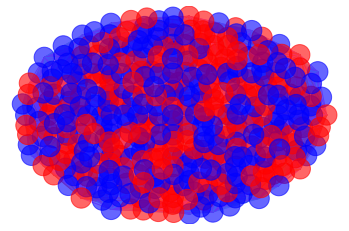

ForceAtlas2 plot without edge weight influence


In [ ]:
print_fa2(G_110, iter=1000, edge_weight='agree', edge_weight_influence=0)
print('ForceAtlas2 plot without edge weight influence')

Figure 7: Network constructed using the ForceAtlas2 Package without edge weight influence. Node colors indicates party (red = Republican, blue = Democratic), edge color depends on the party of the connected nodes (red = Republican-Republican, blue = Democratic-Democratic, purple = Democratic-Republican).

100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


BarnesHut Approximation  took  7.57  seconds
Repulsion forces  took  77.13  seconds
Gravitational forces  took  0.57  seconds
Attraction forces  took  334.05  seconds
AdjustSpeedAndApplyForces step  took  1.72  seconds


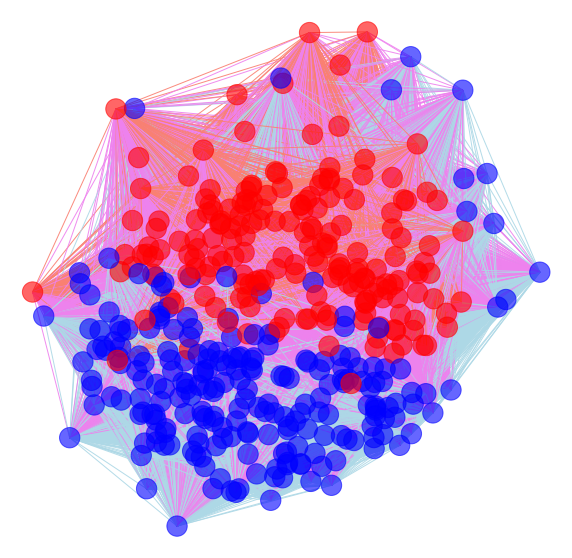

ForceAtlas2 plot with edge weight influence


In [ ]:
print_fa2(G_110, iter=1000, edge_weight='agree', edge_weight_influence=1)
print('ForceAtlas2 plot with edge weight influence')

Figure 8: Network constructed using the ForceAtlas2 Package with edge weight influence. Node colors indicates party (red = Republican, blue = Democratic), edge color depends on the party of the connected nodes (red = Republican-Republican, blue = Democratic-Democratic, purple = Democratic-Republican). Each edge is a bill that the members both have voted towards. The closer the edges, the more they have voted the same towards their common bills (e.g. the closer the nodes the more they agree). 

The only difference between the two graphs is the edge weight influence. Each edge from a node is a connection to another member (they have voted towards the same bill), and the more bills they have voted the same for, the higher the weight, thus the closer the nodes are to eachother. Nodes that lie outside the "center" either disagree with many other nodes, or they agree with so many different nodes that they do not belong to one centroid. 

It is clear that because of the high density of the network, the edges themselves do not form a meaningful graph (all nodes are equally connected). However, by allowing the network layout to be influenced by the edge weights (total agree in this case) we are able to see some meaningful relationships in the graph - In this case, a clear red group and blue group with an overlap in the middle. 

Now we will check the degree of the nodes to see how dense the network actually is.

In [ ]:
print("Number of nodes:", len(G_110))
print(f"Number of edges:{len(G_110.edges())} \n")
print("Count of degrees:")
print(pd.DataFrame([d for _, d in G_110.degree()]).value_counts())

Number of nodes: 415
Number of edges:85905 

Count of degrees:
414    415
dtype: int64


We can conclude that the graph is complete, meaning all possible edges are present, resulting in all nodes having the exact same degree, namely 414.

This scenario is not very informative, since we are looking for meaningful connections in a graph that is fully connected, thus we will investigate the different edge attributes to trim the edges. 

It was expected from the beginning, since all members are expected to vote on roughly the same rolls throughout their service in congress. By reducing the density of the graph, we hope to reveal some insights that are not visible in this graph however. The first ForceAtlas2 plot shows there may be meaningful relationships to be derived from the edge weights.

Inspired by M. Ángeles Serrano et al. (2009) we want to explore two options for reducing the density of the graphs, while maintaining information in the network [4].
1. Setting a global minimum threshold for edge weights for edges to be included in the graph
2. Using an algorithm to select significant edges, based on edge weights. This is referred to 'Extracting the multiscale backbone' of a network using a disparity filter to select significant edges.

These approached will be implemented and compared, with a focus on maintaining as much weight as possible, since this is where we see the potential of identifying meaningful connections based on the level of agreement between two members.

### Global minimum threshold

The threshold is going to be set at a given percentile of the edge weights in question. For the initial analysis, the relative agreement numbers will be used. This is calculated as: $$\text{agree} = \text{agree yes} + \text{agree no} $$


In [ ]:
def global_threshold_filter(G, weight='agree', percentile=50):
  '''Filter function to identify edges with weights above the percentile threshhold

  Returns
    Reduced graph with relevant edges
  '''

  threshhold = np.nanpercentile(list(nx.get_edge_attributes(G, weight).values()),percentile)
  B = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d[weight] >= threshhold])
  B_node_attr = {k: G.nodes()[k] for k in B.nodes}
  nx.set_node_attributes(B, B_node_attr)

  return B

In [ ]:
def sum_attribute(G, attribute='agree'):
  '''Sums a given attribute, ignoring nan values

  Returns
    Sum of attribute values across edges
  '''
  return np.nansum(list(nx.get_edge_attributes(G, attribute).values()))

This function will be used to calculate the fraction of nodes, weight and edges retained after having filtered out edges that do not meet the edge weight criteria. Note that we wish to keep as much information in the graph as possible, and by applying this filter we assume that edges with higher edge-weights ('agree' in this case) are more meaningful to the network as a whole.

To test the sensitivity to the global edge weight threshold, we apply the filter for various percentiles from 0 to 100 at intervals of 2, calculating the retained nodes, weights and edges for each iteration. The criteria determining which percentile to choose is the highest possible percentile, while 100% of the nodes remain, since we do not want to exclude any representatives from the analysis.

In [ ]:
threshold_dict = {}

for percentile in np.linspace(0, 100, 51):
  # Determing threshold 
  G2 = global_threshold_filter(G_110, weight='agree', percentile=percentile)
  # Creating dict of the different thresholds
  threshold_dict[percentile] = [round(G2.number_of_nodes() / G_110.number_of_nodes(), 2), 
                                round(sum_attribute(G2, attribute='agree')/sum_attribute(G_110, attribute='agree'), 2),
                                round(G2.number_of_edges() / G_110.number_of_edges(), 2)]
# Creating a dataframe
threshold_df = pd.DataFrame.from_dict(threshold_dict, orient='index', columns=['remaining_nodes', 'remaining_weight', 'remaining_edges'])

In [ ]:
print('Threshold Table. All indexes are percentiles:')
threshold_df

Threshold Table. All indexes are percentiles:


remaining_nodes  remaining_weight  remaining_edges
0.0               1.00              1.00             1.00
2.0               1.00              1.00             0.98
4.0               1.00              0.99             0.96
6.0               1.00              0.98             0.94
8.0               1.00              0.97             0.92
10.0              1.00              0.95             0.90
12.0              1.00              0.94             0.88
14.0              1.00              0.92             0.86
16.0              1.00              0.91             0.84
18.0              1.00              0.89             0.82
20.0              1.00              0.88             0.80
22.0              1.00              0.86             0.78
24.0              1.00              0.84             0.76
26.0              1.00              0.83             0.74
28.0              1.00              0.81             0.72
30.0              1.00              0.80             0.70
32.0              1.00              0.78             0.68
34.0              1.00              0.76             0.66
36.0              1.00              0.74             0.64
38.0              1.00              0.73             0.62
40.0              1.00              0.71             0.60
42.0              1.00              0.69             0.58
44.0              1.00              0.67             0.56
46.0              1.00              0.66             0.54
48.0              1.00              0.64             0.52
50.0              1.00              0.62             0.50
52.0              1.00              0.60             0.48
54.0              1.00              0.58             0.46
56.0              1.00              0.56             0.44
58.0              0.99              0.54             0.42
60.0              0.99              0.51             0.40
62.0              0.96              0.49             0.38
64.0              0.95              0.47             0.36
66.0              0.95              0.44             0.34
68.0              0.95              0.42             0.32
70.0              0.94              0.39             0.30
72.0              0.92              0.37             0.28
74.0              0.91              0.34             0.26
76.0              0.90              0.32             0.24
78.0              0.90              0.30             0.22
80.0              0.88              0.27             0.20
82.0              0.86              0.24             0.18
84.0              0.84              0.22             0.17
86.0              0.82              0.19             0.14
88.0              0.80              0.16             0.12
90.0              0.77              0.14             0.10
92.0              0.72              0.11             0.08
94.0              0.66              0.08             0.06
96.0              0.56              0.06             0.04
98.0              0.41              0.03             0.02
100.0             0.00              0.00             0.00

We see that at the 56th percentile, we start losing nodes, which we are not interested in. At this percentile, 56% of the total edge weights remain, while only 44% of the edges remain. This is positive, however we need to investigate whether the new graph provides any further insights, or if the edges have simply been uniformly removed.

The following function will help summarizing findings in terms of nodes, edges as well as plotting the degree distribution.

In [ ]:
def summarize_graph(G):
  print("Number of nodes:", len(G))
  print(f"Number of edges:{len(G.edges())} \n")

  degree_dist = np.histogram([d for _, d in G.degree()]);
  fix, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5));

  ax1.scatter(degree_dist[1][:-1], degree_dist[0]);
  ax1.set_title('Degree distribution - Linear axes');
  ax1.set_xlabel('Degrees');
  ax1.set_ylabel('Frequency');

  ax2.scatter(degree_dist[1][:-1], degree_dist[0]);
  ax2.set_title('Degree distribution - Log-log axes');
  ax2.set_yscale("log");
  ax2.set_xscale("log");
  ax2.set_xlim(0.9,1000);
  ax2.set_ylim(0.9,1000);
  ax2.set_xlabel('Log(Degrees)');
  ax2.set_ylabel('Log(Frequency)');

  plt.show()

We now plot the network taking only the 56th percentile:

100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


BarnesHut Approximation  took  0.07  seconds
Repulsion forces  took  0.81  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  1.59  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


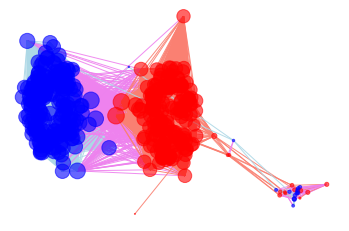

Number of nodes: 414
Number of edges:37841 



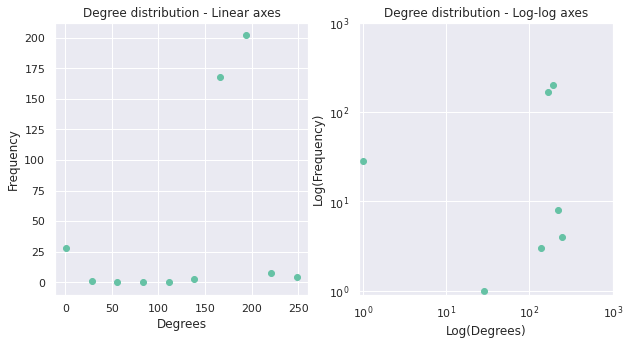

In [ ]:
G = global_threshold_filter(G_110, weight='agree', percentile=56)
print_fa2(G, 10, edge_weight='agree')
summarize_graph(G)

Figure 9: (top) Network constructed using the ForceAtlas2 Package with edge weight influence, and only using the top 56th percentile of edges. Node colors indicates party and edge color depends on the party of the connected nodes. Each edge is a bill that the members both have voted towards. The closer the edges, the more they agree. 
(bottom) Frequency of degree distributions on linear and log-log scale for the network. 

In [ ]:
print('Value counts on degrees.')
print('(Degrees, Value Counts)')
pd.DataFrame([d for n,d in G.degree()]).value_counts().head(10)

Value counts on degrees.
(Degrees, Value Counts)


206    65
177    64
178    41
207    36
208    23
210    18
209    17
176    12
211    10
205     9
dtype: int64

The visualization of the network looks more meaningful, and there are now two clear communities - the two main parties. 

From the degree distribution plots, it is evident that we do not have that many nodes, and many have the same degree. This makes the degree distribution look sparse, and does not form a clear relationship.

We will now try to characterize the network in terms of the density and compare the degree distribution to that of a random network with the same number of nodes and probability of connecting, p.

Erdos Renyi Random Network for Comparison

Probability of connecting: 0.44
Number of nodes: 414
Number of edges:37764 



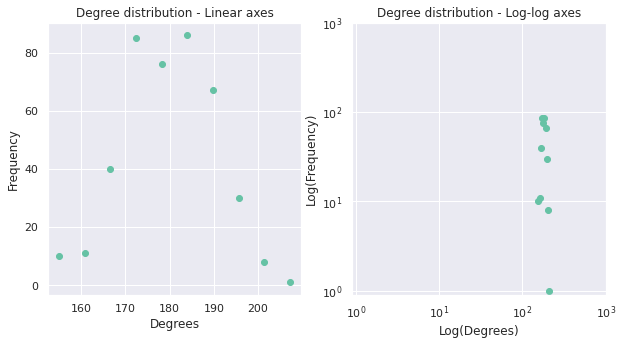

In [ ]:
N = len(G)
k_avg = np.mean([d for n,d in G.degree()])
p = k_avg/(N-1)
print('Erdos Renyi Random Network for Comparison\n')
print(f'Probability of connecting:', round(p,2))

#Generating random network
G_er = nx.erdos_renyi_graph(N,p,seed=42)

summarize_graph(G_er)

Figure 10: Frequency of degree distributions on linear and log-log scale for the network, with a 44% probability of connecting, at a random Erdos Renyi network. 

The easiest way to compare the networks is by plotting the degree distributions on the same chart, to visually inspect the distributions.

In [ ]:
def compare_graphs(G1, lab1, G2, lab2):
  degree_dist1 = np.histogram([d for _, d in G1.degree()]);
  degree_dist2 = np.histogram([d for _, d in G2.degree()]);
  fix, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5));

  ax1.scatter(degree_dist1[1][:-1], degree_dist1[0], label=lab1);
  ax1.scatter(degree_dist2[1][:-1], degree_dist2[0], label=lab2);
  ax1.set_title('Degree distribution - Linear axes');
  ax1.set_xlabel('Degrees');
  ax1.set_ylabel('Frequency');
  ax1.legend();

  ax2.scatter(degree_dist1[1][:-1], degree_dist1[0], label=lab1);
  ax2.scatter(degree_dist2[1][:-1], degree_dist2[0], label=lab2);
  ax2.set_title('Degree distribution - Log-log axes');
  ax2.set_yscale("log");
  ax2.set_xscale("log");
  ax2.set_xlim(0.9,1000);
  ax2.set_ylim(0.9,1000);
  ax2.set_xlabel('Log(Degrees)');
  ax2.set_ylabel('Log(Frequency)');
  ax2.legend();

  plt.show()

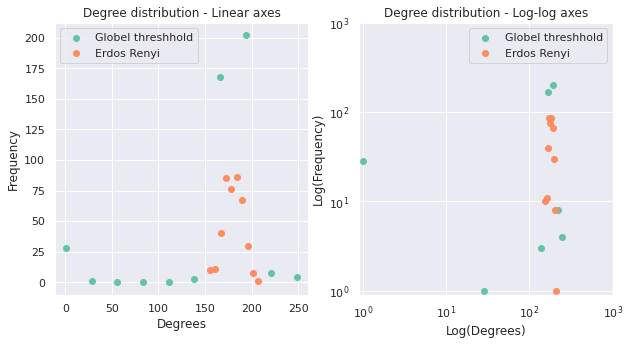

In [ ]:
compare_graphs(G, 'Globel threshhold', G_er, 'Erdos Renyi')

Figure 11: Frequency of degree distributions on linear and log-log scale for both our network, and a random Erdos Renyi network.

Looking at these, it is evident that our network with the global threshold for edge weights approximates that of a random network, however it is difficult to conclude on the distribution. 

We would expect a real random to be in the supercritical regime, however in our case the network is even more connected, and the giant component consumes all nodes. We can check this by seeing if $ \text{<k>} > ln(N)$


In [ ]:
print(f'<k> is: {round(k_avg, 2)} while ln(N) is: {round(np.log(N), 2)}')
print(f'Number of connected components:', nx.number_connected_components(G))

<k> is: 182.81 while ln(N) is: 6.03
Number of connected components: 1


Thus we can conclude that the network in question is in the connected regime, and it is in fact fully connected with all nodes having a degree higher than 1 and only one connected component

Next, we apply another the disparity filter to extract significant edges.

### Disparity filter
Extracting the multiscale backbone using a disparity filter on edge weights is inspired by M. Ángeles Serrano et al. (2009)[4] and will be implemented using code inspired by GitHub user 'aekpalakorn', adapted for our purposes [5].

This approach seeks to identify the most significant edges for each node, rather than simply choosing the ones with the highest edge weights in the entire network. These edges are identified by calculating a significance value (alpha) per edge. Alpha is a measure for how significant the weight of a given edge is compared to the rest of the edges linked to a specific node, and is calculated as follows: 
$$
\alpha_{ij} = 1 - (k - 1) \int_{0}^{p_{ij}}(1+x)^{k-2}dx
$$
where k = degree, x is the edge weight and $p_{ij}$ is the relative weight of the edge out of the total edge weights for that given node. 

This is implemented and applied to the initial graph representing the 110th congress below.

Note that in this case, the alpha value is sought as low as possible, while maintaining all representatives (remaining nodes = 100%)

In [ ]:
def disparity_filter(G, weight='agree'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
    '''
    B = G.copy()
    for u in G:
        k = len(G[u])
        if k > 1:
            sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
            for v in G[u]:
                w = G[u][v][weight]
                p_ij = float(np.absolute(w))/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                nx.set_edge_attributes(B,{(u,v):{'alpha':float('%.4f' % alpha_ij)}})
    return B

In [ ]:
def disparity_filter_alpha_cut(G, alpha_t=0.4):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.

        Args
        ----
        G: Weighted NetworkX graph

        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.

        Returns
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    '''

    B = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha_t])
    B_node_attr = {k: G.nodes()[k] for k in B.nodes}
    nx.set_node_attributes(B, B_node_attr)

    return B

In [ ]:
def create_disparity_df(graph, attribute='agree'):
  '''Creates dataframe to illustrate sensitivity of alpha values in disparity filter

  Returns
    Dataframe containing list of alpha values and corresponding remaning fractions of nodes, weights and edges
  '''
  disparity_dict = {}
  G = disparity_filter(graph, weight=attribute)

  # Generate graphs for all alphas in the interval 0 to 1, with 0.02 steps
  for alpha in np.linspace(0,1,51):
    G2 = disparity_filter_alpha_cut(G, alpha_t=alpha)
    disparity_dict[alpha] = [round(G2.number_of_nodes() / G.number_of_nodes(), 2), round(sum_attribute(G2, attribute=attribute)/sum_attribute(G, attribute=attribute), 2),round(G2.number_of_edges() / G.number_of_edges(), 2)]
  
  return pd.DataFrame.from_dict(disparity_dict, orient='index', columns=['remaining_nodes', 'remaining_weight', 'remaining_edges'])

In [ ]:
print('Table displaying remaining nodes, weight and edges for different values of alpha:')
create_disparity_df(G_110, attribute='agree')

Table displaying remaining nodes, weight and edges for different values of alpha:


remaining_nodes  remaining_weight  remaining_edges
0.00             0.00              0.00             0.00
0.02             0.00              0.00             0.00
0.04             0.02              0.00             0.00
0.06             0.03              0.00             0.00
0.08             0.05              0.00             0.00
0.10             0.06              0.00             0.00
0.12             0.06              0.00             0.00
0.14             0.06              0.00             0.00
0.16             0.07              0.00             0.00
0.18             0.08              0.00             0.00
0.20             0.09              0.00             0.00
0.22             0.11              0.00             0.00
0.24             0.17              0.00             0.00
0.26             0.26              0.01             0.01
0.28             0.92              0.12             0.10
0.30             1.00              0.43             0.34
0.32             1.00              0.53             0.43
0.34             1.00              0.56             0.45
0.36             1.00              0.57             0.47
0.38             1.00              0.58             0.47
0.40             1.00              0.62             0.51
0.42             1.00              0.71             0.61
0.44             1.00              0.83             0.75
0.46             1.00              0.91             0.86
0.48             1.00              0.95             0.91
0.50             1.00              0.97             0.93
0.52             1.00              0.97             0.94
0.54             1.00              0.98             0.95
0.56             1.00              0.98             0.95
0.58             1.00              0.98             0.96
0.60             1.00              0.99             0.96
0.62             1.00              0.99             0.97
0.64             1.00              0.99             0.98
0.66             1.00              0.99             0.98
0.68             1.00              1.00             0.99
0.70             1.00              1.00             0.99
0.72             1.00              1.00             0.99
0.74             1.00              1.00             0.99
0.76             1.00              1.00             0.99
0.78             1.00              1.00             0.99
0.80             1.00              1.00             0.99
0.82             1.00              1.00             1.00
0.84             1.00              1.00             1.00
0.86             1.00              1.00             1.00
0.88             1.00              1.00             1.00
0.90             1.00              1.00             1.00
0.92             1.00              1.00             1.00
0.94             1.00              1.00             1.00
0.96             1.00              1.00             1.00
0.98             1.00              1.00             1.00
1.00             1.00              1.00             1.00

From the table above, the alpha value is found to be 0.3, which maintains 43% of edge weights and only 34% of edges.

100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


BarnesHut Approximation  took  0.07  seconds
Repulsion forces  took  0.80  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  1.26  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


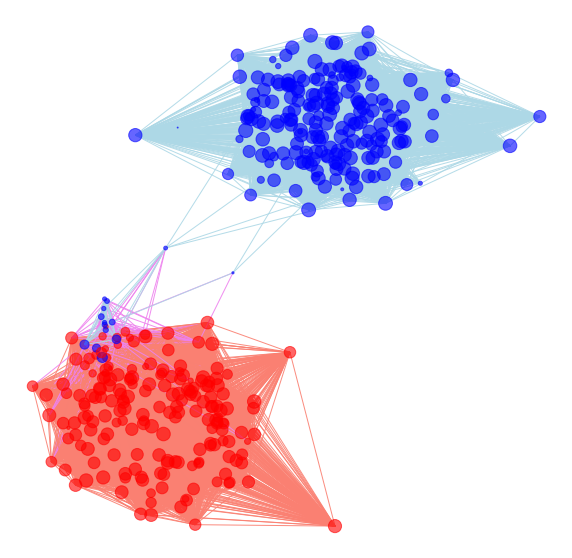

Number of nodes: 414
Number of edges:28876 



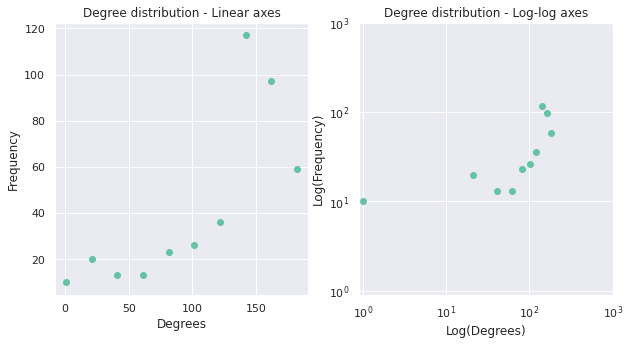

In [ ]:
G = disparity_filter(G_110, weight='agree')
G = disparity_filter_alpha_cut(G, alpha_t=0.3)
print_fa2(G, 10, edge_weight='agree')
summarize_graph(G)

Figure 12: (top) Network constructed using the ForceAtlas2 Package with edge weight influence, and alpha value of 0.3. Node colors indicates party and edge color depends on the party of the connected nodes. Each edge is a bill that the members both have voted towards. The closer the edges, the more they agree. (bottom) Frequency of degree distributions on linear and log-log scale for the network.

Using the disparity filter to reduce the number of edges results in a much different graph than using the global filter. There are now way fewer links between the two parties, and the degree distribution is also affected. 

Let us compare to a random network, to see how similar our disparity graph is to that.

Probability of connecting: 0.34


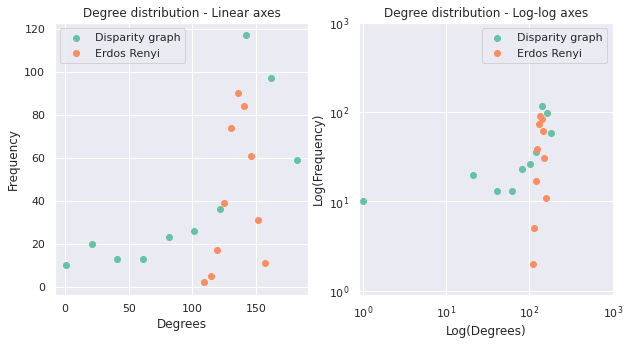

In [ ]:
N = len(G)
k_avg = np.mean([d for n,d in G.degree()])
p = k_avg/(N-1)
print(f'Probability of connecting:', round(p,2))

#Generating random network
G_er = nx.erdos_renyi_graph(N,p,seed=42)

compare_graphs(G, 'Disparity graph', G_er, 'Erdos Renyi')

Figure 13. Frequency of degree distributions on linear and log-log scale for both the network using alpha=0.3 (blue) and a random Erdos Renyi network (with probability of connecting at 34%).

Interestingly, the disparity graph results in a denser degree distribution, in the sense that more nodes have higher degrees compared to a random network. This is probably caused by the fact that all intra-party nodes are connected, and there are hardly any edges crossing the parties, therefore we do not see any 'low/mid degree' nodes.


We can now check if the network with the disparity filter is in the connected regime by seeing if $ \text{<k>} > ln(N)$ holds:


In [ ]:
print(f'<k> is: {round(k_avg, 2)} while ln(N) is: {round(np.log(N), 2)}')
print(f'Number of connected components:', nx.number_connected_components(G))

<k> is: 139.5 while ln(N) is: 6.03
Number of connected components: 1


Thus we can again conclude that the network is in the connected regime, and it is in fact fully connected with all nodes having a degree higher than 1 and only one connected component

### Comparing methods of reducing edges

In the following, we will look into which of the two edge reduction methods make sense for the remainder of the study.
This will be investigated by plotting the remaining weight and edges versus the remaining nodes for a given global edge weight threshold and alpha value.

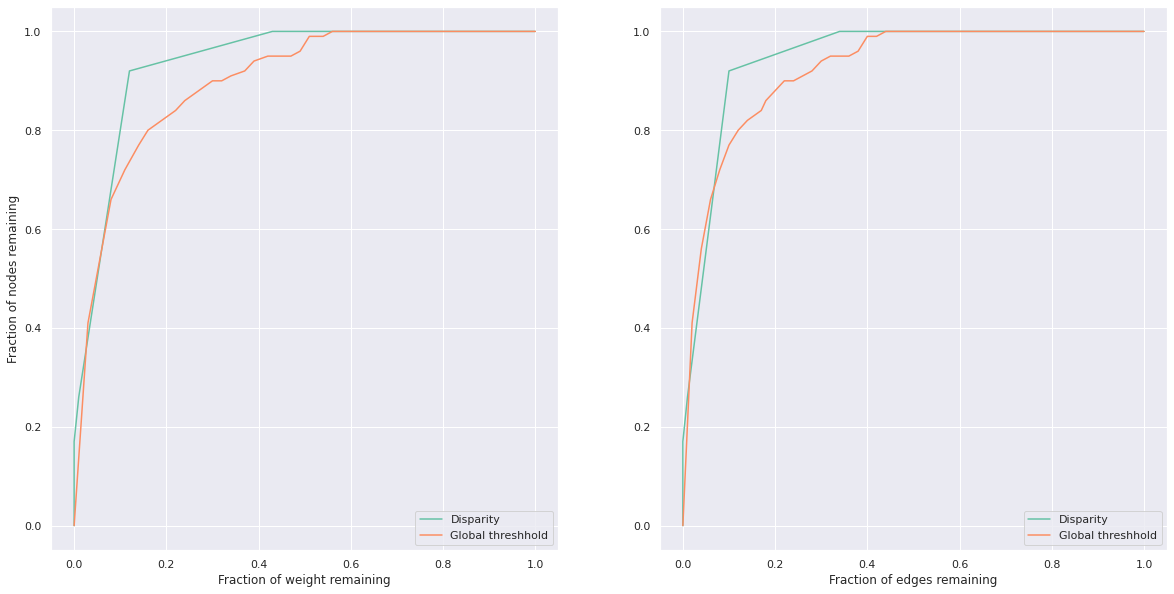

In [ ]:
disparity_df = create_disparity_df(G_110, attribute='agree')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.plot(disparity_df.remaining_weight, disparity_df.remaining_nodes, label="Disparity")
ax1.plot(threshold_df.remaining_weight, threshold_df.remaining_nodes, label="Global threshhold")
ax1.set_xlabel("Fraction of weight remaining")
ax1.set_ylabel("Fraction of nodes remaining")
ax1.legend(loc=4)

ax2.plot(disparity_df.remaining_edges, disparity_df.remaining_nodes, label="Disparity")
ax2.plot(threshold_df.remaining_edges, threshold_df.remaining_nodes, label="Global threshhold")
ax2.set_xlabel("Fraction of edges remaining")
ax1.set_ylabel("Fraction of nodes remaining")
ax2.legend(loc=4)
plt.show()

Figure 14: Plots comparing using the Global Threshold or the Disparity filter for density reduction. The plot on the left displays the fraction of nodes remaining for each fraction of the weights remaining. The plot on the right displays the fraction of nodes remaining for each fraction of the edges remaining. 

Looking at the plots, it is evident that for fewer edges, the disparity maintains more total edge weight as well as nodes, therefore this method for reducing number of edges is preferred. Furthermore, from an analytical standpoint it makes more intuitive sense to have a measure of significance rather than applying an arbitrary global threshold to uniformly remove edges.

Therefore, we decide to continue using the disparity filter, and will now assess what that means for the remainder of the congresses (111th-116th).

### Checking alpha values across congresses

In [ ]:
# Creating the graph for each term
G_110 = create_graph('110')
G_111 = create_graph('111')
G_112 = create_graph('112')
G_113 = create_graph('113')
G_114 = create_graph('114')
G_115 = create_graph('115')
G_116 = create_graph('116')

# creating the disparity filter for each term
df_110 = create_disparity_df(G_110, attribute='agree')
df_111 = create_disparity_df(G_111, attribute='agree')
df_112 = create_disparity_df(G_112, attribute='agree')
df_113 = create_disparity_df(G_113, attribute='agree')
df_114 = create_disparity_df(G_114, attribute='agree')
df_115 = create_disparity_df(G_115, attribute='agree')
df_116 = create_disparity_df(G_116, attribute='agree')

Upon manual inspection of the dataframes above, we see that all congresses require an alpha value between 0.28 and 0.34 to maintain all nodes, and minimizing number of edges, therefore we set the global alpha value to 0.32, to ensure comparability between congresses.

The graphs remaining edges are visualized below.

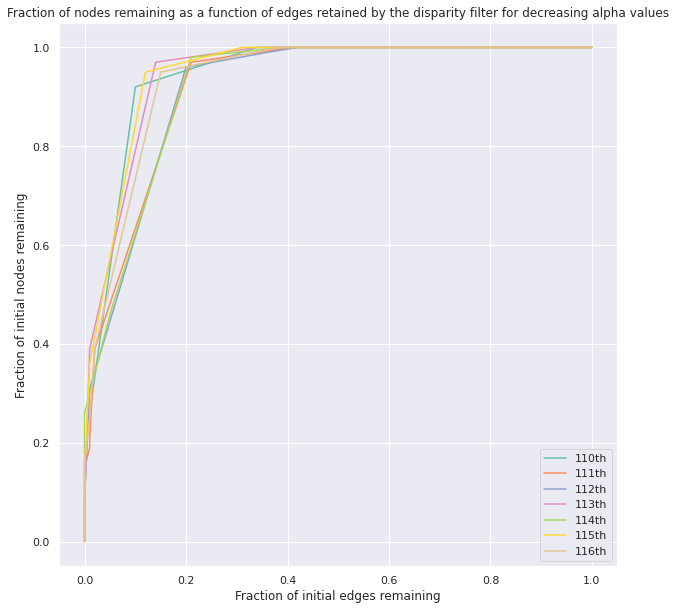

In [ ]:
fig, ax = plt.subplots(figsize=(10,10));
ax.plot(df_110.remaining_edges, df_110.remaining_nodes, label='110th');
ax.plot(df_111.remaining_edges, df_111.remaining_nodes, label='111th');
ax.plot(df_112.remaining_edges, df_112.remaining_nodes, label='112th');
ax.plot(df_113.remaining_edges, df_113.remaining_nodes, label='113th');
ax.plot(df_114.remaining_edges, df_114.remaining_nodes, label='114th');
ax.plot(df_115.remaining_edges, df_115.remaining_nodes, label='115th');
ax.plot(df_116.remaining_edges, df_116.remaining_nodes, label='116th');
ax.legend()
ax.set_xlabel('Fraction of initial edges remaining');
ax.set_ylabel('Fraction of initial nodes remaining');
ax.set_title('Fraction of nodes remaining as a function of edges retained by the disparity filter for decreasing alpha values');
plt.show()

Figure 15: Fraction of nodes remaining as a function of edges retained by the disparity filter for decreasing alpha values for each term.

They all display a similar behavior, which enforces the decision to continue with a common alpha value of 0.34.

Finally, it was decided that the edge weights will constitute 'agree_yes' for the text analysis, rather than the full 'agree', which means an edge is weighted by the number of times two members agree to let a bill pass the congress. This obviously impacts the network, and we will check whether our current assumptions still hold.

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


BarnesHut Approximation  took  0.22  seconds
Repulsion forces  took  0.78  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  1.44  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


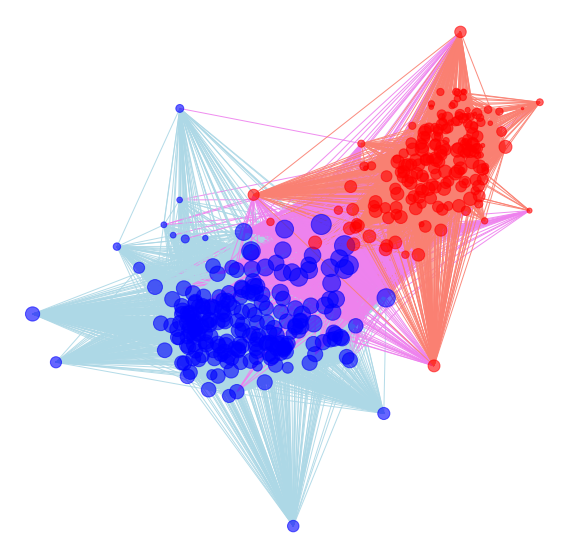

Number of nodes: 414
Number of edges:34711 



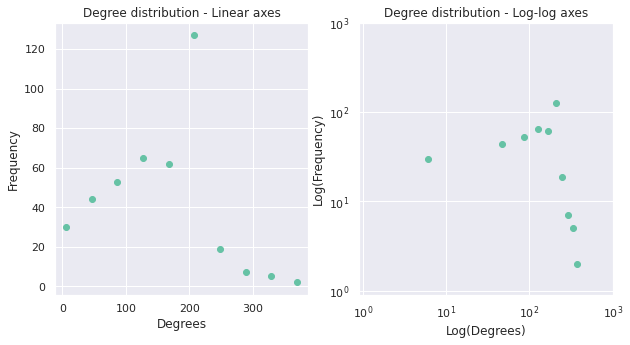

In [ ]:
G = disparity_filter(G_110, weight='agree_yes')
G2 = disparity_filter_alpha_cut(G, alpha_t=0.34)
print_fa2(G2, 10)
summarize_graph(G2)

Figure 16: (top) Network constructed using the ForceAtlas2 Package with agree_yes as edge weight influence , and alpha value of 0.34. Node colors indicates party and edge color depends on the party of the connected nodes. Each edge is a bill that the members both have voted towards. The closer the edges, the more they have voted yes towards the same bill. (bottom) Frequency of degree distributions on linear and log-log scale for the network.

Inspecting the network visually and looking at the summary of nodes, edges and degree distribution, we can confirm that it resembles that of the full 'agree' edge attribute. The reason for continuing with only the 'agree_yes' attribute is simply for interpretation purposes - We would like to find out what the communities agree to pass, and be able to isolate this, rather than having a mix of what they agree to be 'for' and what they agree to be 'against'.

A dictionary is made to contain all the graphs for further analysis.

In [ ]:
alpha = 0.34 # setting global alpha value.

graph_dict = {}

graph_dict['110'] = disparity_filter_alpha_cut(disparity_filter(G_110, weight='agree_yes'), 
                                                alpha_t=alpha)
graph_dict['111'] = disparity_filter_alpha_cut(disparity_filter(G_111, weight='agree_yes'), 
                                                alpha_t=alpha)
graph_dict['112'] = disparity_filter_alpha_cut(disparity_filter(G_112, weight='agree_yes'), 
                                                alpha_t=alpha)
graph_dict['113'] = disparity_filter_alpha_cut(disparity_filter(G_113, weight='agree_yes'), 
                                                alpha_t=alpha)                                                                             
graph_dict['114'] = disparity_filter_alpha_cut(disparity_filter(G_114, weight='agree_yes'), 
                                                alpha_t=alpha)
graph_dict['115'] = disparity_filter_alpha_cut(disparity_filter(G_115, weight='agree_yes'), 
                                                alpha_t=alpha)
graph_dict['116'] = disparity_filter_alpha_cut(disparity_filter(G_116, weight='agree_yes'), 
                                                alpha_t=alpha)
              


## **Analysis 2: Community Detection - Finding Partitions in the Networks**

### Examining the dendogram to get the best partitions

The NetworkX function *best_partition* uses the Louvain algorithm to create a dendogram of the partitions in the graph, then selects the dendogram with the highest partition. Although picking the highest partition makes sense, we wish to further explore this dendogram to obtain all partition levels. If a larger dengogram is produced in a certain time period, we could draw conclusions on community distinctions based on that. 

Another thing to note is the fact that we continue to use 'agree_yes' as the edge weight. It would also make sense to use the disparity significance score, alpha, as edge weights for finding the best partitions, however upon inspection it did not make a big difference, since alpha is a measure of the significance of each edge weight, based on 'agree_yes'. Furthermore, it easens the interpretation of each partition to focus on 'agree_yes', since we know the representatives have both votes for a given bill, which would not necessarily be the case if the edge weight was chosen differently.

In [ ]:
import community
from community import generate_dendrogram, partition_at_level

def creating_dendogram(congress_number, alpha, weight='agree_yes'):
  """Function generate a dendogram of partition from a graph."""
  
  # Creating dendogram with alpha as weight
  dendo = generate_dendrogram(graph_dict[congress_number], weight='agree_yes', random_state=42) 

  return dendo

We can now print the number of levels in this dendogram, along with the distribution for each level. 

In [ ]:
def print_dendo(dendo): 
  """ Function that prints information about the dendogram and its layers"""

  print('Dendogram for Graph:')
  for level in range(len(dendo)):
    print('\nLevel:', level)
    print(f"Distribution in level {level}:")
    print(pd.Series([vals for vals in partition_at_level(dendo, level).values()]).value_counts())


  # best level is the last level:
  bestLevel = len(dendo) - 1
  if bestLevel != 0:
    print('Concatination between levels: ')
    print(dendo[bestLevel])

  print('\nBest level:')
  print(bestLevel)

  return pd.DataFrame([partition_at_level(dendo, bestLevel)], index=[0]).T.rename(columns = {0: 'Partition'})


As an example, we run through how the steps are carried out for term 110. Afterwards, we will runt he same procedure for the other terms as well. 

In [ ]:
dendo_110 = creating_dendogram('110', weight='agree_yes', alpha=alpha)
bestLevel_110 = print_dendo(dendo_110)

Dendogram for Graph:

Level: 0
Distribution in level 0:
0    217
1    197
dtype: int64

Best level:
0


In [ ]:
bestLevel_110

Partition
A000022          0
A000014          0
A000357          0
A000362          1
A000210          0
...            ...
P000555          1
R000574          1
S000097          1
S001148          1
W000273          1

[414 rows x 1 columns]

If our dendogram only has one level, the dendogram equals the best_partition we found using the Louvian Heuristics. In the example above, we see that we only have two partitions in the dendogram, which does not go further than level 0.

We now have an overview of each member's partition. We will add their political party for further overview.

In [ ]:
# Adding political party
df_partition_110 = bestLevel_110.merge(congress_roll[['party', 'state']], 
                                       left_index = True, right_index = True, how='left') 

As mentioned earlier, we used the Python Louvain Algorithm to generate the partitions. The algorithm is an optimizer that uses the modularity measurement (M) to evaluate how well the partitions are. The modularity is measured in a range of (-1,1). According to Barabasi et. al [6], the higher the modularity, the better the community structure is, whereas a lower modularity (closer to 0) means that the network deviates from having communities. If the modularity equals 0, the network is one, large community. In image 9.12 in Barabasi et. al [6], a threshold for the optimal partition is given at M=0.41. Hence, we will use a threshold of $M=0.4$ as an indicator for a good partition. As a final note, when modularity is negative, each node is assigned to its own community. 

We calculate the modularity for term 110:

In [ ]:
modu_110 = round(community.modularity(df_partition_110['Partition'].to_dict(), graph_dict['110']), 2)
print(f"Modularity of partition for term 110: {modu_110}")

Modularity of partition for term 110: 0.32


We see that the modularity is right below the M=0.4 threshold, indicating that the partition is sub-optimal. 

We can repeat this procedure with the other terms as well. All the above steps are gathered in the function *dendo_term* which creates the partitions and the final merged dataframe for a given term. 

In [ ]:
def dendo_term(congress_number, alpha, weight='agree_yes'):
  """ Function that prints dendogram information and 
    creates final dataframe for text analysis for a given term.

    Returns the final partition level (bestLevel) and the concatenated 
    dataframe with political party and state."""

  dendo = creating_dendogram(congress_number, weight='agree_yes', alpha=alpha)
  print(f"\n{congress_number}:")
  bestLevel = print_dendo(dendo)
  df_partition = bestLevel.merge(congress_roll[['party', 'state']], 
                                 left_index = True, right_index = True, how='left') 
  
  modu = round(community.modularity(df_partition['Partition'].to_dict(), graph_dict[congress_number]), 2)
  print(f"\nModularity of best partition for term {congress_number}: \n{modu}")

  return bestLevel, df_partition, modu

In [ ]:
bestLevel_111, df_partition_111, modu_111 = dendo_term('111', alpha=alpha)


111:
Dendogram for Graph:

Level: 0
Distribution in level 0:
0    223
1    181
dtype: int64

Best level:
0

Modularity of best partition for term 111: 
0.24


In [ ]:
bestLevel_112, df_partition_112, modu_112 = dendo_term('112', alpha=alpha)


112:
Dendogram for Graph:

Level: 0
Distribution in level 0:
0    224
1    172
dtype: int64

Best level:
0

Modularity of best partition for term 112: 
0.43


In [ ]:
bestLevel_113, df_partition_113, modu_113 = dendo_term('113', alpha=alpha)


113:
Dendogram for Graph:

Level: 0
Distribution in level 0:
0    238
1    201
dtype: int64

Best level:
0

Modularity of best partition for term 113: 
0.45


In [ ]:
bestLevel_114, df_partition_114, modu_114 = dendo_term('114', alpha=alpha)


114:
Dendogram for Graph:

Level: 0
Distribution in level 0:
1    249
0    189
dtype: int64

Best level:
0

Modularity of best partition for term 114: 
0.45


In [ ]:
bestLevel_115, df_partition_115, modu_115 = dendo_term('115', alpha=alpha)


115:
Dendogram for Graph:

Level: 0
Distribution in level 0:
1    247
0    200
dtype: int64

Best level:
0

Modularity of best partition for term 115: 
0.41


In [ ]:
bestLevel_116, df_partition_116, modu_116 = dendo_term('116', alpha=alpha)


116:
Dendogram for Graph:

Level: 0
Distribution in level 0:
0    237
1    203
dtype: int64

Best level:
0

Modularity of best partition for term 116: 
0.37


We notice that each term only generates two partitions, no further dendogram, thus we could've used the *best_partition* formulation in the *communities* package. We notice that the distribution between the partitions change over time. What will be interesting to examine from these, is how the modularity changes over time, to see if the partitions have become more distinct over time.

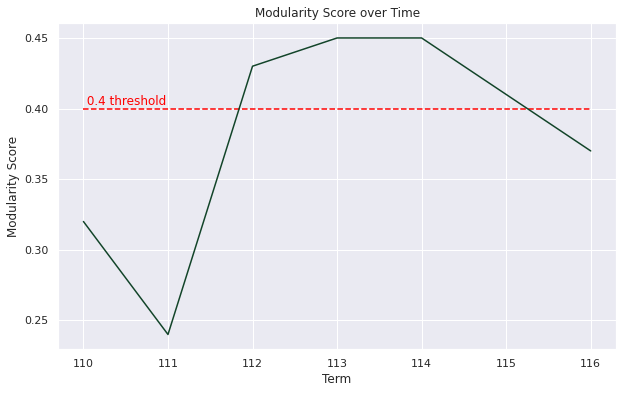

In [ ]:
x = terms
y = [modu_110, modu_111, modu_112, modu_113, modu_114, modu_115, modu_116]

plt.figure(figsize=[10,6])
plt.plot(x,y, color=color)
plt.hlines(y=0.40, color='r', xmin=0, xmax='116', linestyle='dashed')
plt.text('110', 0.41, ' 0.4 threshold', ha='left', va='top', color='r')
plt.xlabel('Term')
plt.ylabel('Modularity Score')
plt.title('Modularity Score over Time')
plt.show()

Figure 17: Modularity score over time for each partition, along with the 0.4 threshold indicator for a good partition.

We notice that the modularity varies greatly, with a minimum at term 111 to a maximum around terms 113-114. In terms 112-115, we have a high modularity meaning the network must be more polarized since the partitions are more distinct. Before term 110 and during the current term, we see a modularity score under the threshold, indicating that the partitions are less distinct. Especially in term 111, we saw a highly suboptimal partition, meaning that the members of the network agreed on more bills. This could also be due to the fact that we only saw a small number of bills being passed in term 111 in figure 4.

What now will be interesting, is to see these distributions visually, to see if we can draw any further conclusions on the polarizations. 

Initially, we modify our graph functions to represent the different partitions instead of the different parties.

In [ ]:
def color_nodes_partitions(G):
  '''Function to determine node colors depending on partitions. 
    Can take up to 6 partitions

  Returns the node colors
  '''
  # for partition [0, 1, 2, 3, 4, 5] we assign the following colors:
  colors = ["Green", "Purple", "Pink", "Orange", "Brown", "Black"]

  # Color nodes
  color_nodes = [colors[nx.get_node_attributes(G,'Partition')[node]] for node in list(G.nodes()) ]

  return color_nodes


def color_edges_partitions(G):
  '''Function to determine edge color depending on partition of start and end node

  Returns (for each partition index)
    grey if same partition
    turquoise if different
  '''
  same_color = "#A0A0A0"
  diff_color = "#40E0D0"

  color_edges = [same_color if nx.get_node_attributes(G, 'Partition')[edge[0]] == nx.get_node_attributes(G, 'Partition')[edge[1]] 
                else diff_color
                for edge in list(G.edges())]

  return color_edges

### Plotting partitions with ForceAtlas2 for different terms

We can now visualize the partitions using ForceAtlas2. To ease the length of the document, we only display terms 111 (lowest modularity), 114 (highest modularity) and 116 (today). 

In [ ]:
# Defining layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=2.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=1,

                          # Log
                          verbose=True)

In [ ]:
def print_fa2_partitions(G, iter, bestLevel, edge_weight='agree_yes', edge_weight_influence=1):
  '''Plotting the graph using positions provided by ForceAtlas2 based on partitions

  Returns
    Nothing
  '''
  nx.set_node_attributes(G, bestLevel.to_dict()['Partition'], 'Partition')

  col_nodes = color_nodes_partitions(G)
  col_edges = color_edges_partitions(G)
  nod_size = size_nodes(G)
  positions = fa2_pos(G, iter, edge_weight, edge_weight_influence)

  nx.draw_networkx_nodes(G, positions, node_size=nod_size, node_color=col_nodes, alpha=0.6)
  nx.draw_networkx_edges(G, positions, edge_color=col_edges, alpha=0.4)
  plt.rcParams["figure.figsize"] = [10,10]
  plt.axis('off')
  plt.ion()
  plt.show()

100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s]


BarnesHut Approximation  took  8.18  seconds
Repulsion forces  took  106.65  seconds
Gravitational forces  took  0.58  seconds
Attraction forces  took  115.12  seconds
AdjustSpeedAndApplyForces step  took  1.70  seconds


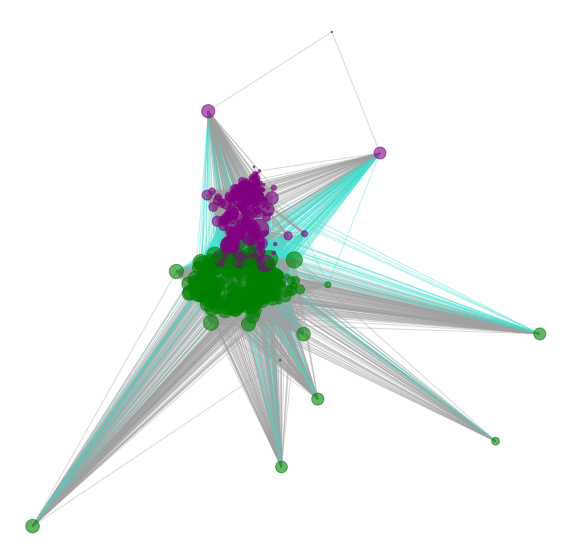

Network plot using ForceAtlas2 package for term 111


In [ ]:
print_fa2_partitions(graph_dict['111'], iter=1000, bestLevel=bestLevel_111 ,edge_weight='agree_yes', edge_weight_influence=1)
print('Network plot using ForceAtlas2 package for term 111')

Figure 18: Network constructed using the ForceAtlas2 Package where each node is a member for term 111. Node colors indicates partition and edge color depends on the partition of the connected nodes. Each edge is a bill that the members both have voted towards. The closer the edges, the more they agree.

100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


BarnesHut Approximation  took  8.66  seconds
Repulsion forces  took  81.24  seconds
Gravitational forces  took  0.63  seconds
Attraction forces  took  168.30  seconds
AdjustSpeedAndApplyForces step  took  1.84  seconds


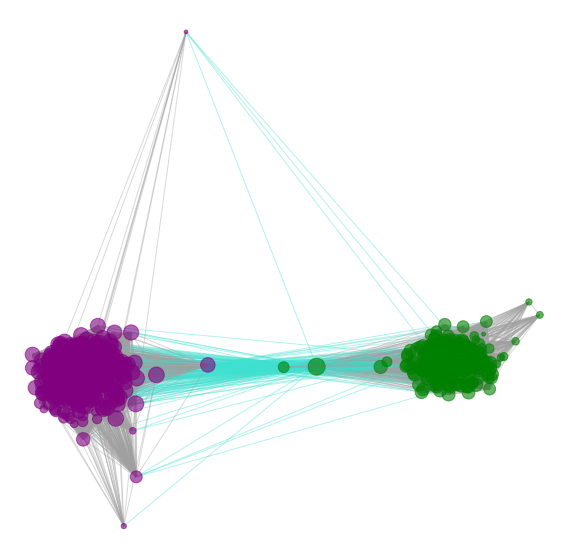

Network plot using ForceAtlas2 package for term 114


In [ ]:
print_fa2_partitions(graph_dict['114'], iter=1000, bestLevel=bestLevel_114 ,edge_weight='agree_yes', edge_weight_influence=1)
print('Network plot using ForceAtlas2 package for term 114')

Figure 19: Network constructed using the ForceAtlas2 Package where each node is a member for term 114. Node colors indicates partition and edge color depends on the partition of the connected nodes. Each edge is a bill that the members both have voted towards. The closer the edges, the more they agree.

100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


BarnesHut Approximation  took  8.49  seconds
Repulsion forces  took  115.16  seconds
Gravitational forces  took  0.63  seconds
Attraction forces  took  152.37  seconds
AdjustSpeedAndApplyForces step  took  1.85  seconds


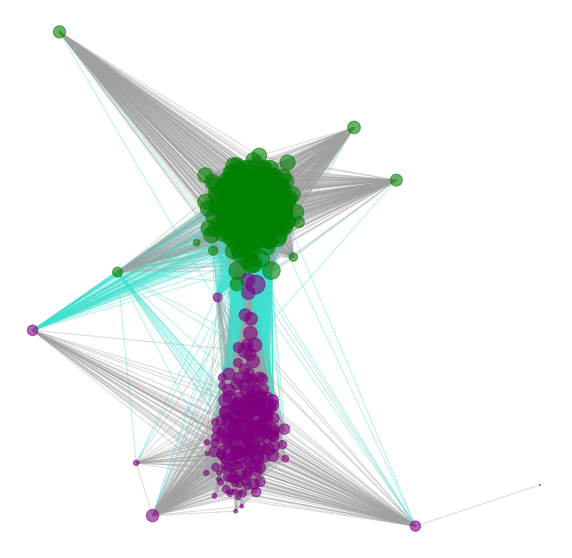

Network plot using ForceAtlas2 package for term 116


In [ ]:
print_fa2_partitions(graph_dict['116'], iter=1000, bestLevel=bestLevel_116 ,edge_weight='agree_yes', edge_weight_influence=1)
print('Network plot using ForceAtlas2 package for term 116')

Figure 20: Network constructed using the ForceAtlas2 Package where each node is a member for term 116. Node colors indicates partition and edge color depends on the partition of the connected nodes. Each edge is a bill that the members both have voted towards. The closer the edges, the more they agree.

These plots confirm what we saw in the Modularity plot in figure 17; in term 111 we experienced the lowest modularity, while we in term 114 experienced the highest modularity. It can clearly be seen that the two partitions are more distinct in term 114 than in term 111, which supports this hypothesis. This, the partitions were more polarized in term 111 than in term 114. Today (term 116) we see that we are somewhat in-between. There is still a fairly clear separation between the two partitions. 

## **Analysis 3: Text Analysis Based on Partitions in Analysis. 2**

In this section, we are interested in performing a text analysis of the bill/issue summaries, using the partitions found above. Specifically, we are interested in evaluating which words are both unique and frequent for each partition. Since the partitions are found based on bills that the representatives vote *yes* for, this analysis aims to give an indication of the topics that are for in each partition. This will help us to understand if there is a voting pattern over time for the partitions, as well as what topics each partition stands for.

### Defining functions for text analysis

In the following sections, we will take the reader through the text analysis by defining and explaining the functions generated to clean the data, analyze, and create the final word clouds. Each step of the process has been defined as a function. In the end, these will be easily executed for each term to generate the final wordclouds. 

#### Text Cleaning Functions

Before we can use the summaries for text analysis, we need to prepare the summary data for analysis. We will use the NLTK library to load all stopwords and punctuations to be cleaned from the data. We then create a function that will clean the raw string and return a cleaned list of tokens. 

In [ ]:
# Loading all stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Initialize nltk stemmer 
porter = nltk.PorterStemmer()

We then create functions that will perform the data cleaning, tokenize and return the tokens

In [ ]:

def text_processing(text, stem = False):
    """ Function that cleans the raw summary string and tokenizes it afterwords.
    Process:
    1) Tokenize data using NLTK library
    2) Remove stopwords using NLTK library
    3) Remove single punctuation by using the String libraries list of punctuation
    4) Remove start- and end punctiations from tokens
    5) Remove single characters as these would clutter the tokenized dataset
    6) Potentially add stemming

        Returns cleaned list of tokens (from our assignment 2) """

    # items to remove
    common_bill_words = ['act', 'nan', 'sec', 'secretary', 'house', 'ref', 
                         'consideration', 'forthsets', 'res', 'forth', 'rule', 
                         'set', 'sets', 'order', 'senate', 'report', 'state',
                         'res ', ' res', 'program', 'conference', 'fh1b']
    years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', 
             '2015', '2016', '2017', '2018', '2019', '2020']
    string_punctuation = list(string.punctuation)

    # Creating a list of items (stop words and punctuations) to be removed
    remove_items_list = stop_words + string_punctuation + common_bill_words + years
    
    text = str(text)
    text = text.replace('|', ' ').replace('\n', ' ').replace('[', '').replace(']', '')
    
    #Tokenize
    tokens = nltk.tokenize.word_tokenize(text.lower())
    
    tokens = [w for w in tokens if w not in remove_items_list]  # Remove stopwords and punctuation
    tokens = [w for w in tokens if '=' not in w]                # Remove remaining tags and the like
    tokens = [w.strip(string.punctuation) for w in tokens]      # Remove remaining punctuation around words (beginning/ends)
    tokens = [w for w in tokens if len(w) > 1]                  # Remove single characters
    if stem:
      tokens = [porter.stem(w) for w in tokens]                 # Stem word
    
    return tokens

The processes of cleaning the data starts with tokenizing the data using the *NLTK Library* [7], which is also used to remove stopwords. We then remove stopwords, punctuations, as well as single characters. We are interested in the most common words that are also interesting - e.g., the word "and" will not be very interesting. Notice removing these common words would not be necessary given the idf weights introduced below, since they are likely to be present in almost all summaries. However, we chose to include them to explain the process. We have also added some common words in bills, as well as all yearly indications. An option of stemming (Porter) is added as well. 

Running this code on the summary string will thus clean the code. We can now proceed to define the functions needed to generate the word clouds. 


### Functions to generating wordclouds

In order to generate the wordclouds, we need to go through a number of steps - each defined as a function below. Overall, we will be calculating the TF-IDF list for each term, and the higher the score the large the word in the wordcloud. TF stands for Term Frequency, which is a count of how many times a word appears in a summary. Since we in the basic statistics saw that the summaries have varying length, we will also be calculating a relative term frequency, which is the term frequency normalized by the length of the summary to get the relative importance. We then calculates the IDF weights for each term. IDF stands for Inverse Document Frequency, and will in this report be calculated using the formula $$log(\frac{N}{n_t}),$$ where N is the number of partitions and $n_t$ is the number of documents containing term t. IDF serves the purpose of measuring how frequently a word appears in each partition. Notice since the maximum amount of partitions we have is 2, the idf weight can only take values of either 0 or 0.3 ($log(\frac{2}{2})$ and $log(\frac{2}{1})$). This will be discussed in the *Discussion* section later on. 

Furthermore, due to limited capacity of the notebook, we have decided to only include a certain quantile of the roll calls. For each edge (member-member pair), we found the roll calls they have both voted yes for. In this table, we then count for each roll call how many times each roll call had a member-member connection (e.g. sorting out which roll calls most representatives have votes yes for). We then find the 80th percentile of most frequent summaries in each partition, and sort these, leaving us with only the 20% most frequent roll calls for each partition.

The process that will be repeated for each term (in same order as functions)
* **func: add_partition**: Add the found partition to the edge data. If the two members in that edge share the same partition, they recieve that index, otherwise they will get index 2.
* **func: top_rolls_dict**: Filter to only keep the top 20% most frequency roll informations in each partition. 
* **func: text_processing_rolls**: Perform text processing on these 100 most frequent rolls by using the text_processing function we defined above.
* **func: term_dict_create**: Process and concatenate the summaries in each partition to one, long processed string, creating a dictionary where each partition is a key, and the concatenated, long text string is the value. 
* **func: term_frequency** Create a function that calculates the term frequency of the summary string.
* **func: TF**: Apply the Term Frequency (TF) function to the values of the dictionary created above, e.g. the text string in each partition.
* **func: word_count**: Calculate $n_t$ in the IDF calculation by returning a count of each word in the term frequency table.
* **func: run_idf_per_word**Calculate the IDF weights per partition using the formula described above. 
* **func: tf_idf_calculation**: Calculate the final TF-IDF score for each word in each partition by multiplying the relative term frequencies with the IDF weights. 

Each function will be presented below.

In [ ]:
def term_edge_load(congress_number): 
  with open(f'edges_rolls_agree_{congress_number}.p', 'rb') as fp:
    edge_dict = pickle.load(fp)
  return edge_dict 


def term_partition_load(congress_number):
  df_partition = {}
  df_partition['110'] = df_partition_110
  df_partition['111'] = df_partition_111
  df_partition['112'] = df_partition_112
  df_partition['113'] = df_partition_113
  df_partition['114'] = df_partition_114
  df_partition['115'] = df_partition_115
  df_partition['116'] = df_partition_116

  return df_partition[congress_number]

def add_partition(edge_data, partition_data):
  """ Function that takes the edge data (e.g. the df where each row represents 
      an edge between two members, and adds a partition column to the df that 
      has the value 1 if both edges are in partition 1, 0 if in partition 0, else nan. 
      Notice this function needs to be modified in case more partitions are present. 
      
      Returns data where partition column is added. 
      Format of return df: |memberA|memberB|Partition|list of rolls that edge agree on|
      
      """

  data = pd.DataFrame(columns = ['member_1', 'member_2', 'partition', 'rolls_agree'])
  data['member_1'] = [member[0] for member in edge_data.keys()]
  data['member_2'] = [member[1] for member in edge_data.keys()]
  data['rolls_agree'] = [value for value in edge_data.values()]
  

  
  # Looping through member pairs 
  temp0_partition_data =  partition_data[partition_data['Partition'] ==0 ].index.tolist()
  temp1_partition_data =  partition_data[partition_data['Partition'] ==1 ].index.tolist()            

  # 0 if both members are in partition 0, 1 if in partition 2, else 2. 
  data['partition']  = [ 0 if ((member1 in temp0_partition_data  ) & (member2 in temp0_partition_data )) 
                           else 
                         1 if ((member1 in temp1_partition_data ) & (member2 in temp1_partition_data )) 
                           else 
                         2 
                           for member1, member2 in edge_data.keys()]  
  return data


def top_rolls_dict(edge_data, topQuantile):
  """ Function that find the top N most agreed on rolls.
      
      Returns dict with partitions as keys and list of top N rolls as values """
  
  unique_partition = np.sort(edge_data['partition'].unique())
  top_rolls = {}
  rolls = {}

  for partition in unique_partition:
    rolls_agree_df = edge_data[edge_data['partition'] == partition]
    roll_dict = Counter(chain.from_iterable(rolls_agree_df.rolls_agree))                     # Creates dict where keys are roll call IDs and values are counts
    
    rolls[partition] = pd.DataFrame.from_dict(roll_dict, orient='index').reset_index().rename(columns ={0:'count'}) # Count of roll call 

    top_rolls[partition] = rolls[partition][rolls[partition]['count'] >= rolls[partition]['count']\
                                            .quantile(topQuantile)]['index'].to_list()# Getting the keys as a list, so we have a list of the top quantile roll call IDs for that term. 
  return rolls, top_rolls


def text_processing_rolls(issue_data, top_rolls, stem ):
  """ Function that filters the roll_summary table initially created to filter 
      out all rows that contain roll IDs not in the list of topN roll calls. 
      Then applies the text processing function to the issue summaries that are left
      and adds these as a column to the dataframe.

      Returns the roll_summary table with a processed string for vizualisation """

  all_rolls = []
  for partition in top_rolls.keys():
    all_rolls = all_rolls + list(top_rolls.values())[partition]

  roll_final_top = issue_data[issue_data['Roll-id'].isin(all_rolls)]

  roll_final_top['processed_list'] = roll_final_top['summary'].apply(lambda x: text_processing(x, stem = stem))
  roll_final_top['processed_string'] = roll_final_top.apply(lambda x: TreebankWordDetokenizer().detokenize(x['processed_list']), axis=1)
  roll_data = roll_final_top

  return roll_data


def term_dict_create(roll_data, top_rolls):
  """ Functions that creates a dict that has partitions as keys 
    and concatenated long text string of summaries as values
    
    Returns this dict """

  term_dict = {} # join all those that are in partition 0 and 1
  
  for partition, rolls in top_rolls.items():
    data_temp = roll_data[roll_data['Roll-id'].isin(rolls)]
    temp_text = ' '.join(data_temp['processed_string'].tolist())

    term_dict[partition] = temp_text

  return term_dict

def term_frequency(text):
    """ Function that counts the frequency of each term in a text string
        by using the package CountVectorizer.

        Returns the word and the count of each word (used in TF function)"""

    vectorizer = CountVectorizer()    # Initialize CountVectorizer 
    transformed_text = vectorizer.fit_transform(text) # Transform the text
    count_vect_feature_name = pd.DataFrame(vectorizer.get_feature_names(), columns=['word'])  # Extract feature names 
    count_vect_text = pd.DataFrame(transformed_text.toarray().sum(axis=0), columns=['value']) # Extract the matrix of token counts and sum for each words 
    
  # Combine Word and value
    return pd.concat([count_vect_feature_name, count_vect_text], axis=1, ).sort_values(by='value', ascending=False)

def TF(term_dict):
  """ Creating TF by applying our term frequency function 
      also calculating the relative value.

      Returns term frequency dictionary where each partition is key, and the 
      values are the words and the corresponding TF value and relative TF value."""

  term_TF = {}
  for k, v in term_dict.items():
    term_TF[k] = term_frequency(pd.Series(v))

  for k, v in term_TF.items():
    term_TF[k]['rela_value'] = term_TF[k]['value'] / term_TF[k]['value'].sum()

  return term_TF

def word_count(term_TF):
  """ Function that returs a count of how many partitions the word appears in. """

  df_word_count = []
  for partition in term_TF.keys():
    df_word_count.extend(term_TF[partition]['word'])

  df_word_count = pd.Series(df_word_count).value_counts()
  
  return df_word_count

def idf_per_word(term_dict, data, df_word_count):
  """Function that calculates the IDF per word 
    using formula log(N/n_t) for each word in the data. 
    N = number of partitions
    n_t = df_word_count[word], which is the number of partitions the word appear in

    Returns the result of IDF calculation """

  N = len(term_dict.keys()) #number of partitions
    
  return pd.DataFrame([[word, math.log(N/df_word_count[word])] for word in data['word']]
                        ).rename({0:'word', 1:'idf'}, axis = 1
                                 ).sort_values(['idf', 'word'], ascending=False)

def run_idf_per_word(term_dict, term_TF, df_word_count):
  """ Function that runs idf_per_word for each line in term_TF
  
  Returns a dictionary where each partition is a key
  and each corresponding value is a dataframe with words 
  and their corresponding idf weight calculated using idf_per_word """


  term_IDF = {}
  for k, v in term_TF.items():
    term_IDF[k] = idf_per_word(term_dict, term_TF[k], df_word_count)
  
  return term_IDF


def tf_idf_calculation(term_IDF, term_TF):
  """ 
  Function that creates the TF_IDF calculation for each word in the summary
  Returns a dict where each partition is a key which each contains a dictionary 
  with word as key and TF-IDF as value (from our assignment 2)"""

  term_TF_IDF = {}

  # Getting list of words 
  for k, v in term_IDF.items():
    word_list = {}
    
    # For each of these words, we extract the tf_values and idf_values calculated above
    # The word list is then calculated as the sum of these two, outputted in the community_TF_IDF list.
    for word in term_IDF[k]['word']:
        tf_value = term_TF[k][term_TF[k]['word'] == word]['rela_value'].values
        idf_value = term_IDF[k][term_IDF[k]['word'] == word]['idf'].values
        word_list[word] = (tf_value * idf_value)[0]
    term_TF_IDF[k] =  word_list

  return term_TF_IDF

In order to create the wordcloud, we will only need the term_TF_IDF dictionary. Hence, we create a function that runs all the functions above, and returns a final term_TF_IDF dictionary for that term. This way, we can easily scale the execution for each term. 

In [ ]:
def tf_idf_create(congress_number, topQuantile, roll_summary, stem = False):
  """ Function that executes all functions and returns the term_TF_IDF 
      for that term """ 
      
  edge_data = term_edge_load(congress_number)
  partition_data = term_partition_load (congress_number)
  
  edge_partition_data = add_partition(edge_data, partition_data)
  rolls, top_rolls = top_rolls_dict(edge_partition_data, topQuantile)
  roll_data = text_processing_rolls(roll_summary, top_rolls, stem)
  term_dict = term_dict_create(roll_data, top_rolls)
  term_TF = TF(term_dict)
  df_word_count = word_count(term_TF)
  term_IDF = run_idf_per_word(term_dict, term_TF, df_word_count)
  term_TF_IDF = tf_idf_calculation(term_IDF, term_TF) # term TF IDF

  return term_TF_IDF

Before the above function can be run for all the congress numbers, we need to find the optimal number of rolls summaries which should be used. We will be looking at the 20% most frequent roll calls. 

We can now run this function for each congress number (term) to create the final dictionary that will be loaded into the wordcloud. The dictionary contains a key for each partition, and within each partition, a word is key and the corresponding TF-IDF number is the value. 

Furthermore, we add a function that counts the number of democrats/republicans in each partition, as this will be added to the title of the wordcloud

In [ ]:
def count_party(congress_number):
  """ Function that creates a dict where each key is a partition, and 
      each partition contains the political party and the value counts for each"""
  
  partition_data =  term_partition_load(congress_number)
  count_dict = {}
  
  # looping through each partition
  for partition in partition_data.Partition.unique():
    count_dict[partition] = partition_data[partition_data['Partition'] == partition]['party'].value_counts()

  return count_dict

Finally, we define the function that will print the wordclouds for each partition for each congress year (term).

In [ ]:
def show_wordcloud(term_TF_IDF, title, congress_number, no_words=10):
    """Function that shows the wordclouds for each partition for each term"""
    
    partition_data =  term_partition_load (congress_number)
    counting = count_party(congress_number) # Getting the party counts for each parition 
    mask = np.array(Image.open('test.jpg')) # mask frame to define the shape of the wordcloud
    
    plt.figure(figsize=(16,11), frameon=True)

    i = 1
    # looping through all partitions:
    for k in [0,1]:
      try: 
        count_dem = counting[k]['Democratic'] 
      except: 
        count_dem = 0
      try: 
        count_rep = counting[k]['Republican'] 
      except: 
        count_rep = 0

      plt.subplot(2, 2, i).set_title(f"Topic Partition: {str(k)} \n Split: Democratic: {count_dem}, Republican: {count_rep}", fontsize = 16)
      plt.plot()
      fig_wordcloud = wordcloud.WordCloud(max_font_size=150, 
                                          max_words=no_words, 
                                          mask=mask,
                                          background_color="white", 
                                          collocations = False,
                                          width=mask.shape[1],
                                          height=mask.shape[0]
                                          ).generate_from_frequencies(term_TF_IDF[k])
      plt.imshow(fig_wordcloud, interpolation="bilinear")  
      plt.axis('off')
      
      i += 1
    plt.suptitle(title, fontsize=30)
    plt.tight_layout()
    plt.show()

### With and without stemming 

We now test the text analysis based on stemming, to determine if we wish to use stemming in the further analysis. 

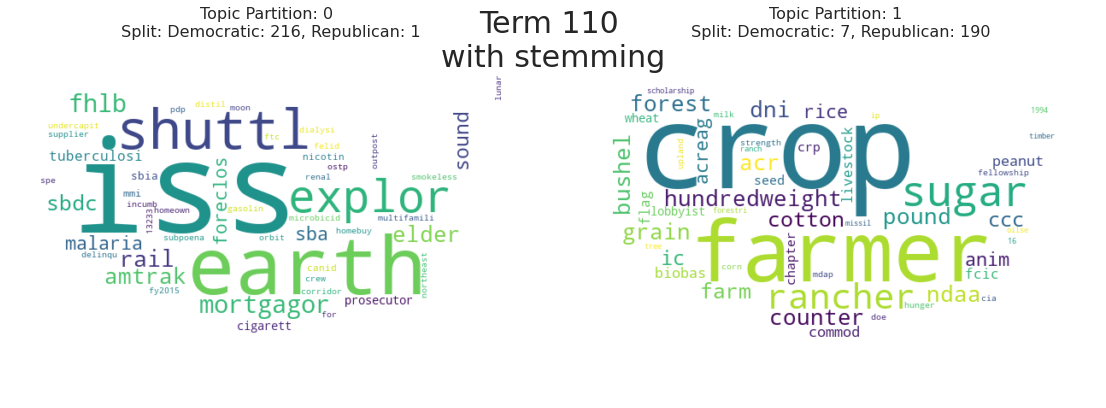

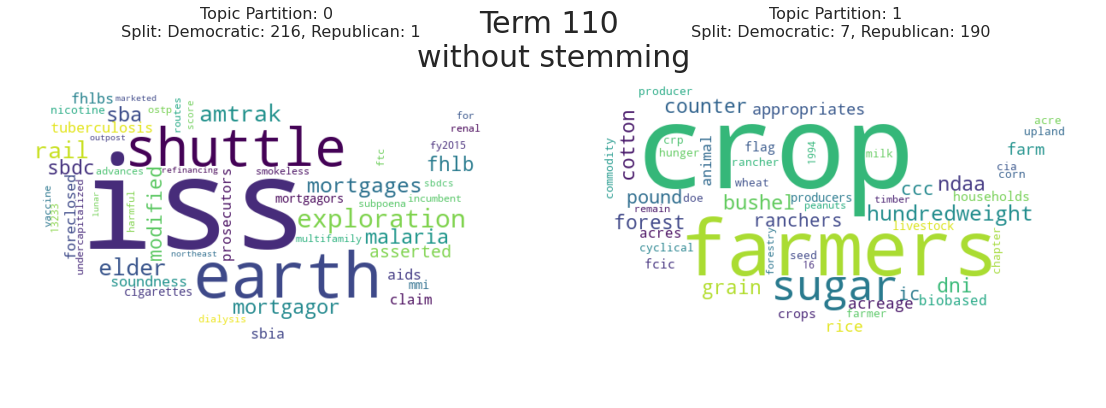

In [ ]:
#with stemming 
term_TF_IDF_stem = tf_idf_create(congress_number='110', topQuantile=0.8, roll_summary = roll_summary, stem = True)
show_wordcloud(term_TF_IDF_stem , title = f"Term 110 \nwith stemming", congress_number = '110', no_words=50)


#without stemming 
term_TF_IDF_without_stem = tf_idf_create(congress_number= '110', topQuantile=0.8, roll_summary = roll_summary, stem = False)
show_wordcloud(term_TF_IDF_without_stem , title = f"Term 110 \nwithout stemming", congress_number = '110', no_words=50)

Figure 21: Wordclouds of most frequent (weighted) words in each partition in term 110, with and without stemming.

Based on these finding, we evaluate that there is no significant difference in using stemming or not in this example. If this was to be optimized, we would need a stemming algorithm that was industry specific. Thus, we continue without stemming as we evaluate that an industry specific stemmer may be better, and we do not improve our  analysis by using a standard one. 

### Printing the wordcloud

We can now print the final wordclouds for each partition in each term:

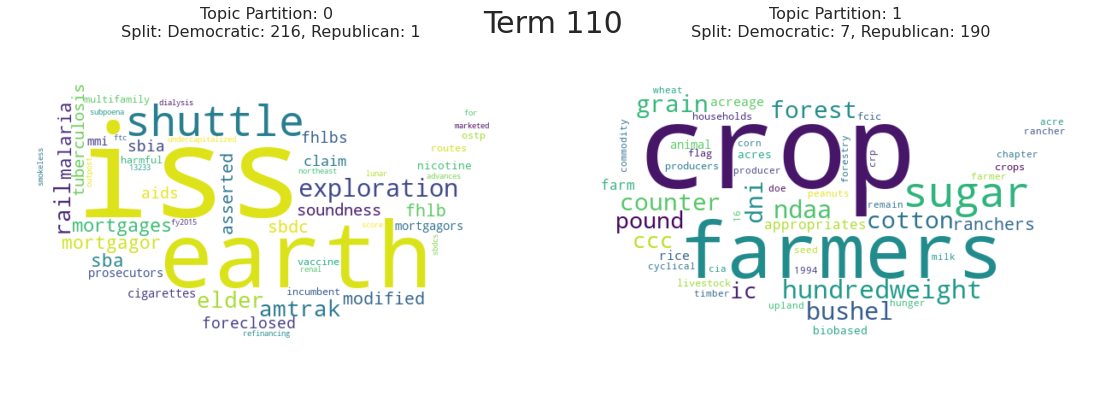

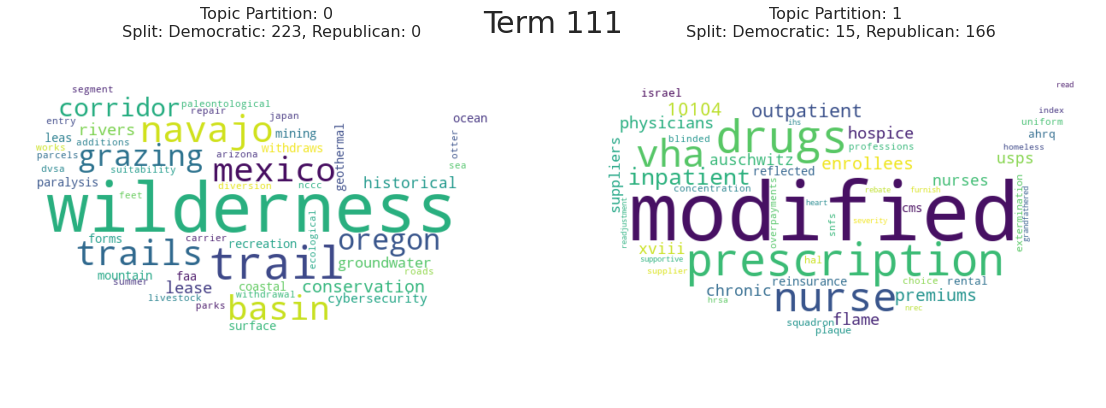

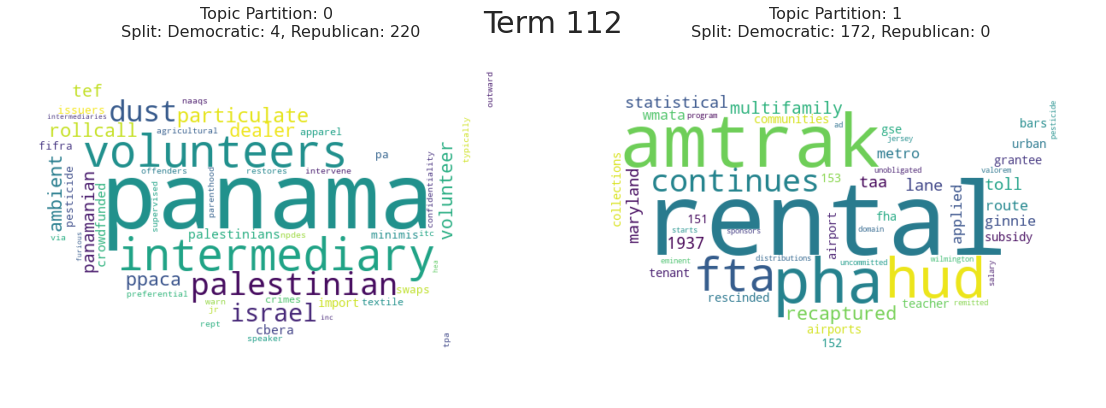

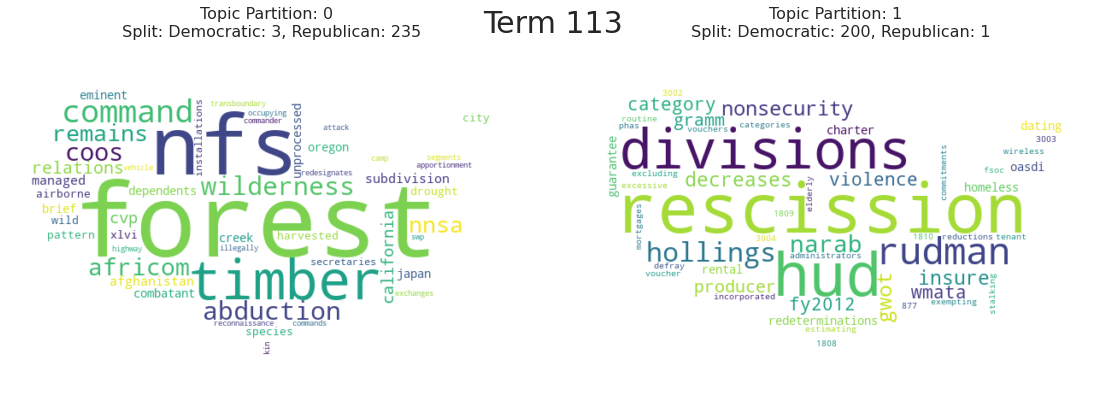

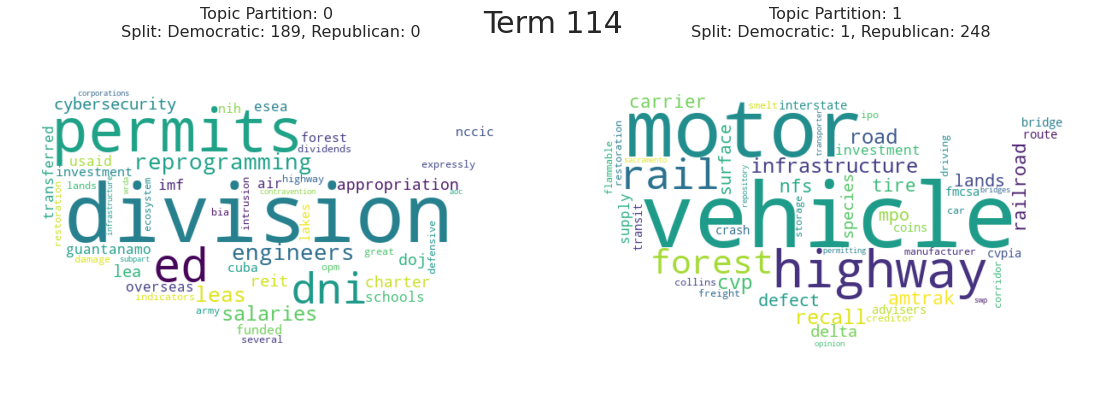

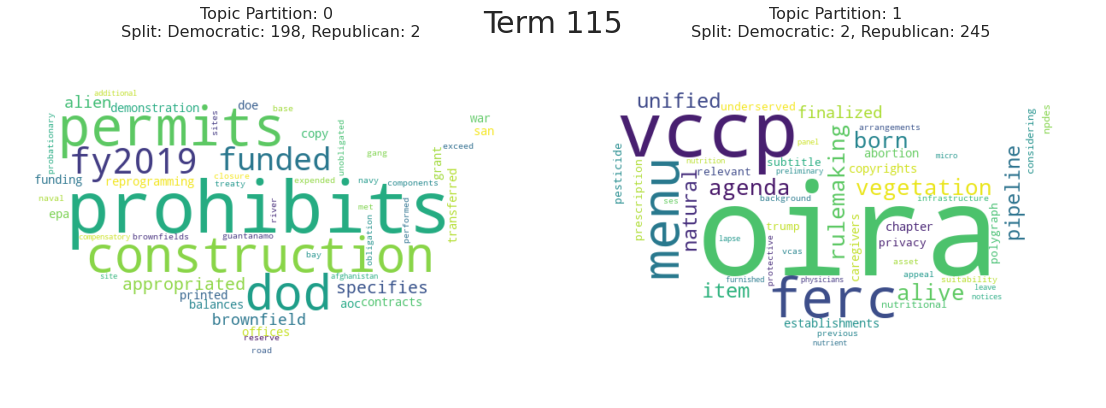

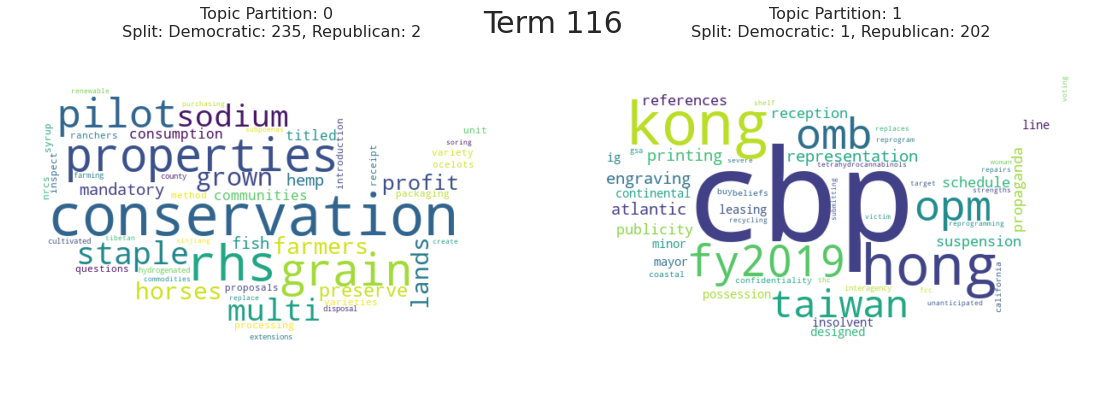

In [ ]:
term_TF_IDF = {}
for term in ['110', '111', '112', '113', '114', '115', '116']:
  term_TF_IDF[term] = tf_idf_create(congress_number= term, topQuantile=0.8, roll_summary = roll_summary, stem = False) 
  show_wordcloud(term_TF_IDF[term] , title = f"Term {term}", congress_number = term, no_words=50)

Figure 22: Wordclouds of most frequent (weighted) words in each partition in each term.

Overall, we notice that the split between partitions are highly based on political party, which confirms our hypothesis that there seem to be a clear distinction between the two political parties in terms of what bills they vote yes for. Furthermore, as we look at the modularity of these, we see that while there is still a clear polarization, the strength of this polarization has been changing over the years, with 111 having a "weaker" separation, and 114 having a more distinct separation. 

A few trends in the wordclouds stood out, which we will be highlighting here for each term:

* **110 (2007-2008)** was fairly separarated. The 2008 Food, Conservation and Energy act, a five-year agricultural bill, was passed, which is evident in partition 1. We see that this partition is highly Republican dominated, which makes sense as we know many states known for farming vote Republicans. 
* **111 (2009-2010)** saw lowest modularity. We also see that this is the term where Partition 1 has the most democrats in a republican-dominated partition. Also seems that this term, partition one (republican dominant) is highly concentrated around words from the medical industry, which is a topic that typically divided people. The democratic majority were mostly voting towards bills around wildlife conservation, seen in words like wilderness, rivers, trails, conservation etc. This is most likely due to the 2010 Wildlife Conversation Act.
* In **2011-2012 (term 112)**, Amtrak (American railroad service on the East coast) celebrated their 40th anniversary and announced a large remodeling of their services. This appeared to be a hot topic for the democrats. In the same year, Obama also passed a Free-Trade agreement with Panama and other countries (hot topic for republicans in the wordcloud). 
* In term **113 (2013-2014)** we once again saw a heavy amount of frequent words around farming in the Republican-dominated partition. 2014 is the year where the wildlife act came into force, which appear to be an act that many republicans votes yes for. 
* In term **114 (2015-2016)**, the republican-dominant partition was keen on infrastructure (and forests), while the democratic-dominant partition appeared to be keen on academics. 
* In term **115 (2017-2018)**, a new president was put into office. While agricultural terms were still a hot topics for the republican-dominant partition, the Office of International Regulatory Affairs (OIRA) was the dominant term. The democratic-dominant partition appeared to be keen on construction and the financial year of 2019 (FY2019). 
* In term **116 (2019-2020)**, we notice even more international regulatory affairs, as well as the rise of the Coronavirus pandemic. Words like "Taiwan", "Hong", "Kong", as well as the Customs and Boarder Control (cbc) were hot topics in the Republican party, while the topics of the democratic party was more spread out. 


While there are no clear voting patterns to be drawn from the wordclouds, we do notice that is appears to be the Republicans who solemnly vote yes on bills directed towards the agricultural sector. 


# 4. Discussion

Overall, we believe the overall project that was carried out was with a great success. We were surprised to see that the partitions formed actually were dividing the two parties, and that we were actually able to see somewhat of a distinction between the parties. It has been exciting to evaluate all the different network-related questions you can ask from this type of data, and we believe there could be many more insights derived from this dataset. 

## Revisiting the hypotheses 

This analysis was carried out using a hypothesis driven approach. In the following section, we will be evaluating these hypotheses.

**Hypothesis 1: It is possible to perform a high-level model of the representatives of the US Congress based on the votes they have casted during roll calls over the years, using advanced network analysis and natural language processing.**

In this project, we were able to successfully create a high-level model of the representatives based on the roll calls over the years. We were able to achieve this using both network theory as well as natural language processing techniques, while being able to tie all the analytical tools together. 


**Hypothesis 2: There are clear distinctions between the two political parties in terms of what bills they vote yes for, and they have become more polarized over the years.**

When building the networks and examining the summaries of the bills, it was clear to us that there indeed is polarization between the members based on the bills they vote yes for. In the network, we saw a clear distinction between the two parties in the partitions they were separated in based on their voting patterns. While we were not able to clearly state that they have become more polarized over the years, we were able to detect that the polarization has changed over the years, ranging from a modularity score of 0.22 in term 111 to a score of 0.41 in term 114. The low modularity score in term 111 was also evident in the wordcliud for that term, where we saw that 15 democrats were added to the Republican-dominated partition. Whether this is due to the topics of term 111, or the low number of bills in 111, we no not know. 


**Hypothesis 3: After finding communities based on bills that representatives vote yes for, it will be possible to understand what subjects polarizes the communities by performing text analysis on the summaries of the bills they vote yes for.**

While we were able to perform text analysis and determine what words were frequent in the bills that each partition voted towards, this analysis will not be sufficient evidence to confirm the hypothesis that there is a clear structure of the subjects that polarizes the communities. While we were able to see some trends, due to the nature of the idf weight formula, these words are not necessarily those that separate the waters for each partition. For example, we know that the political parties have very different views on taxes. However, they could both be voting for a bill that lowers taxes and a bill that raises taxes, hence the word "taxes" would likely be removed.

## Assumptions and improvements

During the project, we had to make assumptions and evaluate different choices on how to carry out the analysis. Below, we will walk through some steps of improvement and/or missing parts.

**IDF formula**
* It is worth noticing that the choice of IDF formulation might not have been the best choice of weighting formula in this case. Since we only have two partitions, the weighting is rather harsh since a word will get weight 0 if the word is present in both partitions $(log(2/2)$. We tried using the Smooth IDF as well, but with no significant improvement.
* This is an important factor to keep in mind when examining the wordclouds. While they do show frequent words of bills from each partition, it is not necessarily the most frequent words for that partition, it is solemnly the most frequent words that are not mentioned in the summary of the other partition. 

**Agree_yes weight**
* It is difficult to actually draw conclusions on words because if word "gun" eg is mentioned, it could both be voting yes to a law for guns, or a law banning guns. This is also why sentiment analysis would've been difficult, as a mention of the word *gun* both could be present in a bill allowing guns and a bill prohibiting guns. 

**Collocations**
* One thing that might have improved the text analysis is including collocations. In the word clouds, we do see words that commonly appear together, where both words are significant, most noteworthy is 'Hong' and 'Kong' in the word clouds for the 116th congress. This might have revealed more relationships and meaningful patterns about the partitions.

**Creating edges**
* From the analysis, it was found that 'agree_yes' would be the most intuitive edge weight to be used for generating the graphs. This decision resulted in rather distinctively divided communities, which made it difficult to fully investigate the polarization of congress over time. Edges could have been created differently, to focus on relationships between bills or otherwise, which may have yielded different and more insightful results. This project illustrated one approach, and recognize the many possibilities with this kind of data.


**Disparity** 
* The choice of most agree upon rolls to use in the text analysis. The arbitrary choice to focus on a given quantile of the summaries impacts the foundation of the entire text analysis, therefore it may have been worth trying other approaches to this particular selection process in order to only allow significant rolls that define a particular partition to enter the actual text analysis. 


**Stemming**
* With regards to stemming; we examined the resulting word clouds with and without stemming to determine which approach yielded the best results. Furthermore, we found that the Porter stemmer was the most accurate for our purposes, however in the end it did not significantly improve interpretability and significance of relevant words, thus we decided against using stemmning. In future studies, it may be relevant to have an 'industry-specific' steming method, that is familiar with legislative terms to avoid strange truncations of words. 

**Taking the analysis one step further; house committees, political party caucuses or states**
* It may have made sense to further subdivide the groups of politicians, since the data is available, however we decided to focus on delivering on the hypotheses rather than taking a fully explorative approach to the project. One aspect that may have been interesting to examine is the inclusion of house committees in the analysis. Bills are often examined in the various committees, which specializes in for example agriculture. This is also the source of most bill proposals, thus it is a significant part of the congress and legislative system in the United States.

# 5. Contributions

Please note that this project was carried out in full collaboration between all team members, and sparring was done in all sections between all members. The table below thus exhibits who has been the main contributor/lead in each section. 

| Section                    | Lead       |
|----------------------------|------------|
| Introduction               | Iben       |
| Webscrape                  | Andreas    |
| Data Description           | Benedicte  |
| Goals and hypotheses      | Iben       |
| Data Cleaning              | Andreas    |
| Basic Stats                | Benedicte  |
| Func. for generating edges | Iben       |
| Graph construction and analysis | Andreas       |
| Disparity Filter           | Benedicte  |
| Comparing methods of reducing edges | Iben       |
| Checking alpha values across congress | Andreas       |
| Examining Dendograms for best partitions | Benedicte       |
| Plotting partitions with ForceAtlas2 | Iben       |
| Defining functions for text analysis | All       |
| Functions to generate wordclouds | Andreas       |
| With and without stemming | Benedicte       |
| Printing the wordclouds | Iben       |
| Revisiting the hypetheses | Andreas       |
| Assumptions and improvements | Benedicte       |

# References

[1] Lobodemonte (Erik), Congress Scraping, (2020), GitHub Repository, https://github.com/lobodemonte/big-data-for-public-policy 

[2] "Congress Profiles: US House of Representatives: History, Art & Archives." Web. 09 Dec. 2020. Accessed at https://history.house.gov/Congressional-Overview/Profiles/115th/ 

[3] Bhargav Chippada, forceatlas2, (2020), Github Repository, https://github.com/bhargavchippada/forceatlas2 

[4] Serrano, M. Ángeles, Marián Boguná, and Alessandro Vespignani. "Extracting the multiscale backbone of complex weighted networks." *Proceedings of the national academy of sciences* 106.16 (2009): 6483-6488.


[5] aekpalakorn (aek), python-backbone-network, (2016), GitHub Repository, https://github.com/aekpalakorn/python-backbone-network 

[6] Barabási, Albert-László. *Network science*. Cambridge university press, 2016. Chapter 9. 


[7] Bird, Steven, Edward Loper and Ewan Klein (2009), *Natural Language Processing with Python*.  O'Reilly Media Inc.


# Appendix

[1] [Scraping_Congress.ipynb](https://nbviewer.jupyter.org/github/benedictehejgaard/chaos-in-congress/blob/gh-pages/Scraping_Congress.ipynb) (webscraping notebook).

[2] [Data](https://github.com/benedictehejgaard/chaos-in-congress/tree/gh-pages/data) 